# Предсказание продаж товара

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предсказание-продаж-товара" data-toc-modified-id="Предсказание-продаж-товара-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предсказание продаж товара</a></span></li><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Постановка задачи</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Таблица-sales" data-toc-modified-id="Таблица-sales-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Таблица <code>sales</code></a></span></li><li><span><a href="#Таблица-stocks_on_days" data-toc-modified-id="Таблица-stocks_on_days-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Таблица <code>stocks_on_days</code></a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Модель-SARIMAX" data-toc-modified-id="Модель-SARIMAX-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Модель SARIMAX</a></span><ul class="toc-item"><li><span><a href="#Разработка-Grid-Search-для-модели-SARIMAX" data-toc-modified-id="Разработка-Grid-Search-для-модели-SARIMAX-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Разработка Grid Search для модели SARIMAX</a></span></li><li><span><a href="#Выбор-лучшей-конфигурации-для-модели-SARIMAX" data-toc-modified-id="Выбор-лучшей-конфигурации-для-модели-SARIMAX-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Выбор лучшей конфигурации для модели SARIMAX</a></span></li></ul></li><li><span><a href="#Градиентный-бустинг-CatBoost" data-toc-modified-id="Градиентный-бустинг-CatBoost-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Градиентный бустинг CatBoost</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Подготовка-функций" data-toc-modified-id="Подготовка-функций-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Подготовка функций</a></span></li><li><span><a href="#Выбор-лучшей-конфигурации-гиперпараметров-для-модели-CatBoost" data-toc-modified-id="Выбор-лучшей-конфигурации-гиперпараметров-для-модели-CatBoost-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Выбор лучшей конфигурации гиперпараметров для модели CatBoost</a></span></li></ul></li><li><span><a href="#Нейронная-сеть-для-временного-ряда" data-toc-modified-id="Нейронная-сеть-для-временного-ряда-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Нейронная сеть для временного ряда</a></span><ul class="toc-item"><li><span><a href="#Vanilla-LSTM" data-toc-modified-id="Vanilla-LSTM-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Vanilla LSTM</a></span></li><li><span><a href="#Stacked-LSTM" data-toc-modified-id="Stacked-LSTM-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Stacked LSTM</a></span></li><li><span><a href="#Многошаговая-LSTM" data-toc-modified-id="Многошаговая-LSTM-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Многошаговая LSTM</a></span></li></ul></li><li><span><a href="#ИТОГ" data-toc-modified-id="ИТОГ-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>ИТОГ</a></span></li></ul></div>

In [4]:
from clickhouse_driver import Client
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import pmdarima.arima
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

from catboost import CatBoostRegressor
from datetime import date, datetime, timedelta
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from joblib import Parallel, delayed

%matplotlib inline
plt.style.use('ggplot')
from tensorflow import keras

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#PATH = 'Datasets/imprice/' # local
PATH = '/content/drive/MyDrive/DataScience/imprice/' # colab

# Постановка задачи

Требуется провести анализ данных и сделать предсказания продаж в штуках на последующую неделю для товара `7d185936-7a60-11eb-ba7f-4a6a34607ded`.

# Загрузка данных

Загрузим датасеты из файлов.

In [21]:
products = pd.read_csv(PATH + 'products.csv')
sales = pd.read_csv(PATH + 'sales.csv')
stocks_items = pd.read_csv(PATH + 'stocks_items.csv')
stocks_on_days = pd.read_csv(PATH + 'stocks_on_days.csv')
warehouse = pd.read_csv(PATH + 'warehouse.csv')

Посмотрим на загруженные датасеты и предвариельно проанализируем данные, с которыми в дальнейшем буде работать.

Импортируем датасеты для товара  `7d185936-7a60-11eb-ba7f-4a6a34607ded`.

In [22]:
products

,item_id,brand_id,name
0,7d185936-7a60-11eb-ba7f-4a6a34607ded,a2c5d335-815e-11eb-ba83-4a6a34607ded,NaN


В таблице `products` мы ожидаемо получили одну строку с идентификатором бренда, соответствующим нашему товару. Для наших целий этот датасет не пригодится.

In [23]:
sales.head(5)

,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
0,2021-01-04 00:00:00,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,3547355649947603906,0.00,1,59.99,53.5
1,2021-01-04 00:00:00,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,4908248033917346488,0.00,1,59.99,53.5
2,2021-01-04 00:00:00,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,1134184689814738432,0.00,1,59.99,53.5
3,2021-01-04 00:00:00,bb818041-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,765388806314934293,0.00,1,59.99,53.5
4,2021-01-04 00:00:00,d91c6b6b-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,15616877688297015768,59.99,1,59.99,53.5


В таблице **`sales`** содержатся данные о продажах. А именно:

- `date` - дата продажи 
- `warehouse_id` - идентификатор склада, 
- `item_id` - идентификатор нашего товара, 
- `order_number` - номер заказа, 
- `price` - цена единицы товара, 
- `quantity` - количество единиц товара в заказе, 
- `amount` - стоимость заказа (цена, умноженная на количество единиц товара в заказе), 
- `sebes` - себестоимость единицы товара

In [24]:
stocks_items

,stock_id,item_id,quantity
0,4787ce96-7a69-11eb-ba7f-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,15
1,126055b5-2c17-11ec-ba94-8141c2516b9e,7d185936-7a60-11eb-ba7f-4a6a34607ded,2
2,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,3
3,708b9941-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6
4,bb818041-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,1
5,e1627618-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,5
6,f6e80261-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,-2
7,d24bc91d-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,-2
8,e523eaae-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6
9,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6


В таблице **`stocks_items`** содержится информация о балансе товара на складах.

- `stock_id` - идентификатор склада, 
- `item_id` - идентификатор нашего товара, 
- `quantity` - количество единиц товара на складе

На двух складах баланс в штуках нашего товара отрицательный. Предположительно, это может быть связано с логистическими особенностями, например, товар куплен с этого склада, но еще на него не поступил. Либо имеет место ошибка при подсчете изначального баланса или что-то в этом роде.

In [25]:
stocks_on_days.tail(5)

,date,stock_id,item_id,start_day,finish_day
4255,2022-01-09 00:00:00,e1627618-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,5,5
4256,2022-01-09 00:00:00,f6e80261-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,-2,-2
4257,2022-01-09 00:00:00,d24bc91d-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,-2,-2
4258,2022-01-09 00:00:00,e523eaae-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6,6
4259,2022-01-09 00:00:00,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6,6


В таблице **`stocks_on_days`** содержится информация об изменении баланса товара на складах.

- `date` - дата изменения записи, 
- `stock_id` - идентификатор склада,
- `start_day` - количество единиц товара на начало дня, 
- `finish_day` - количество единиц товара на конец дня

2022-01-09 на двух складах мы видим отрицательные балансы, соответствующие данным из предыдущей таблицы. Возможно, дальнейший анализ позволит предполжить причину.

In [26]:
warehouse

,id,name
0,4787ce96-7a69-11eb-ba7f-4a6a34607ded,31
1,126055b5-2c17-11ec-ba94-8141c2516b9e,29
2,708b9941-3c6f-11ec-ba95-4a6a34607ded,30
3,bb818041-3c6f-11ec-ba95-4a6a34607ded,36
4,e1627618-3c6f-11ec-ba95-4a6a34607ded,32
5,f6e80261-3c6f-11ec-ba95-4a6a34607ded,13
6,01ffab2c-3c70-11ec-ba95-4a6a34607ded,43
7,0ad8892d-3c70-11ec-ba95-4a6a34607ded,2
8,d24bc91d-50f4-11ec-ba96-4a6a34607ded,10
9,d91c6b6b-50f4-11ec-ba96-4a6a34607ded,17


В таблице **`warehouse`** содержится информация о соответствии идентификатора склада имени склада.

- `id` - идентификатор склада,
- `name` - имя склада

# Предобработка данных

Сначала проанализируем данные в каждой таблице отдельно. Нас в основном будут интересовать две таблицы: `sales` и `stocks_on_days`, т.к. в них есть информация по дням. Сразу преобразуем поле `date` в дату в обоих датасетах.

In [27]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7881 entries, 0 to 7880
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          7881 non-null   object 
 1   warehouse_id  7881 non-null   object 
 2   item_id       7881 non-null   object 
 3   order_number  7881 non-null   uint64 
 4   price         7881 non-null   float64
 5   quantity      7881 non-null   int64  
 6   amount        7881 non-null   float64
 7   sebes         7881 non-null   float64
dtypes: float64(3), int64(1), object(3), uint64(1)
memory usage: 492.7+ KB


In [28]:
sales['date'] = pd.to_datetime(sales['date'], format='%Y-%m-%d')

In [29]:
stocks_on_days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260 entries, 0 to 4259
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        4260 non-null   object
 1   stock_id    4260 non-null   object
 2   item_id     4260 non-null   object
 3   start_day   4260 non-null   int64 
 4   finish_day  4260 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 166.5+ KB


Преобразуем `date` в дату.

In [30]:
stocks_on_days['date'] = pd.to_datetime(stocks_on_days['date'], format='%Y-%m-%d')

## Таблица `sales`

In [31]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7881 entries, 0 to 7880
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          7881 non-null   datetime64[ns]
 1   warehouse_id  7881 non-null   object        
 2   item_id       7881 non-null   object        
 3   order_number  7881 non-null   uint64        
 4   price         7881 non-null   float64       
 5   quantity      7881 non-null   int64         
 6   amount        7881 non-null   float64       
 7   sebes         7881 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2), uint64(1)
memory usage: 492.7+ KB


In [32]:
sales.describe()

,order_number,price,quantity,amount,sebes
count,7.881000e+03,7881.000000,7881.000000,7881.000000,7881.000000
mean,9.327293e+18,29.018286,1.215962,73.103140,62.887013
std,5.398734e+18,30.190997,0.565779,34.144389,57.869118
min,2.034849e+15,0.000000,1.000000,41.000000,46.810000
25%,4.602076e+18,0.000000,1.000000,59.990000,53.500000
50%,9.384644e+18,0.000000,1.000000,59.990000,53.500000
75%,1.403695e+19,59.990000,1.000000,59.990000,53.500000
max,1.844082e+19,72.890000,20.000000,1199.400000,428.000000


Усредненный пользователь заказывает 1.2 нашего товара. При этом 1.2 * 29 не равно 73. Видимо, с какой-то из этих колонок что-то не так. Медианное значение цены - 0, то есть в нашем датасете по меньшей мере половина строк, где товар бесплатен, что странно.

In [33]:
sales['price'].value_counts()

0.00     4092
59.99    3653
72.89      90
64.99      46
Name: price, dtype: int64

Так и есть - в нашем датасете 4092 записи, где товар стоит 0. Это скорее всего ошибка в данных. Хорошо, что для задачи прогнозирования продаж в штуках цена товара нам не понадобится. Однако мы можем приблизительно проследить, как менялась цена за единицу товара.

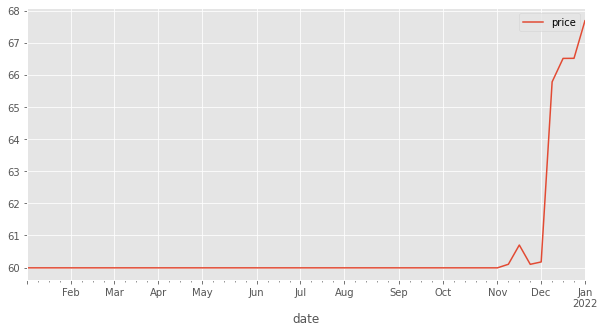

In [34]:
sales[sales['price'] != 0].pivot_table(index=('date'),\
                            values=('price'), aggfunc='mean').resample('1W').mean()\
                .plot(grid=True, figsize=(10, 5),style='-');

Итак, с ноября цена за единицу товара начинает расти.

Сгруппируем данные по номеру заказа и посмотрим суммарное количество единиц товара в одном заказе.

In [35]:
sales.groupby('order_number')['quantity'].value_counts().sort_values(ascending=False)

order_number         quantity
6731018479413670002  1           5
1672391227775584346  1           5
113212051826480409   1           4
2305051651363929932  1           3
9940791630401677462  1           3
                                ..
6304597147929193647  1           1
6303587684150998541  2           1
6301763020603510346  2           1
6296363353016666437  1           1
9385861019613057384  1           1
Name: quantity, Length: 7739, dtype: int64

Итак, одна строка в нашем датасете не соответствует одному заказу, т.к. есть строки с одинаковым номером заказа. Посмотрим на один из них.

In [36]:
sales[sales['order_number'] == 6731018479413670002]

,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
5323,2021-06-29,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6731018479413670002,59.99,1,41.99,53.5
5324,2021-06-29,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6731018479413670002,59.99,1,59.99,53.5
5325,2021-06-29,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6731018479413670002,59.99,1,41.99,53.5
5326,2021-06-29,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6731018479413670002,59.99,1,41.99,53.5
5327,2021-06-29,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6731018479413670002,59.99,1,41.99,53.5


В один день с одного и того же склада было добавлено в заказ 5 единиц товара. Причем поштучно. При этом мы изначально предполагали, что 'amount' есть произведение цены товара на количество товара - это явно прослеживалось по некоторым строкам, где 'quantity' больше 1. Однако здесь эта закономерность не работает в четырех из пяти случаев. Следовательно, можно предположить три варианта: первый - строки в датасете по какой-то причине задублированы, второй - счётчик количества товаров в одном заказе по какой-то причине не всегда работает, третий - количество в каждой строке это покупка вне зависимости от номера заказа.

Чтобы отбросить пару предположений, посмотрим, есть ли среди заказов такие, в которых количество в одной строке больше 1.

In [37]:
sales[sales['quantity']>1].groupby('order_number')['quantity'].value_counts().sort_values(ascending=False).head(30)

order_number          quantity
11296194484965127955  2           2
17309412162316737410  2           2
4049899956522145911   4           2
10232250504558250800  2           2
579778784968965584    2           2
16799693829721819593  2           2
2102220760535183504   2           2
10960844609808534839  3           2
11440118071441749957  2           2
2318083237555896309   2           2
13085452004830543073  2           2
7110878873487874671   2           2
7102228416989677268   2           2
9175776159446999722   2           2
2676459181329578499   2           2
10839405888077023675  2           2
10574565064201526016  2           2
15109576344457757493  2           2
6894026867048799798   2           2
18355528760472315420  2           2
1310799616417822319   2           2
17348045685869597356  4           2
5235063407714053795   2           2
4737158851813872577   2           2
13974361519919532404  2           2
12524739835036680597  2           1
12559081658821231518  2          

У нас есть несколько таких заказов. Посмотрим на некоторые из них.

In [38]:
sales[sales['order_number'] == 4049899956522145911]

,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
335,2021-01-15,126055b5-2c17-11ec-ba94-8141c2516b9e,7d185936-7a60-11eb-ba7f-4a6a34607ded,4049899956522145911,0.0,4,239.96,428.0
336,2021-01-15,126055b5-2c17-11ec-ba94-8141c2516b9e,7d185936-7a60-11eb-ba7f-4a6a34607ded,4049899956522145911,0.0,4,239.96,428.0


In [39]:
sales[sales['order_number'] == 10960844609808534839]

,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
5272,2021-06-28,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,10960844609808534839,0.0,3,179.97,53.5
5273,2021-06-28,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,10960844609808534839,0.0,3,179.97,53.5


In [40]:
sales[sales['order_number'] == 13974361519919532404]

,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
5613,2021-07-13,d24bc91d-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,13974361519919532404,59.99,2,119.98,53.5
5614,2021-07-13,d24bc91d-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,13974361519919532404,59.99,2,119.98,53.5


Вряд ли проблема в счетчике количества единиц товара в одном заказе. Иначе мы могли бы увидеть для одного заказа нечто вроде двух строк с разным 'quantity'. Так же маловероятно, что пользователь сначала купил 4 единицы товара, а затем подумал, что ему не хватает, и заказал ещё 4 единицы. Поэтому логично всё же заключить, что записи задублированы. Возможно, логгирование завязано на не самое удачное событие. Например, на кнопку "Оплатить заказ", а не на подтверждение оплаты. Посмотрим, сколько всего у нас повторяющихся строк.

In [41]:
sales.duplicated().sum()

131

Удалим эти строки.

In [42]:
sales = sales.drop_duplicates().reset_index(drop=True)

Рассмотрим оставшиеся заказы с большим количеством строк, чем 1.

In [43]:
sales['order_number'].value_counts()[sales['order_number'].value_counts() > 1]

785214136477173422      2
16590744060919034086    2
6731018479413670002     2
735175590017064594      2
1670133850376295321     2
1182413268119596500     2
175523352856087190      2
2918464380085550324     2
532907036741686853      2
1128963427423366634     2
14146929096356632958    2
8129142197681254166     2
6345548677911873275     2
348314697940896314      2
9586599714543904593     2
9028684352588784015     2
Name: order_number, dtype: int64

Таких заказов немного, поэтому рассмотрим каждый индивидуально. 

In [44]:
sales[sales['order_number'].isin(\
            sales['order_number'].value_counts()[sales['order_number'].value_counts() > 1].index)]

,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
617,2021-01-23,e1627618-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6345548677911873275,0.00,2,119.66,53.5
618,2021-01-23,e1627618-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6345548677911873275,0.00,1,59.84,53.5
653,2021-01-24,126055b5-2c17-11ec-ba94-8141c2516b9e,7d185936-7a60-11eb-ba7f-4a6a34607ded,1670133850376295321,0.00,1,59.96,53.5
654,2021-01-24,126055b5-2c17-11ec-ba94-8141c2516b9e,7d185936-7a60-11eb-ba7f-4a6a34607ded,1670133850376295321,0.00,1,59.97,53.5
744,2021-01-26,e1627618-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,175523352856087190,0.00,1,59.76,53.5
745,2021-01-26,e1627618-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,175523352856087190,0.00,1,59.77,53.5
1756,2021-02-21,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,9028684352588784015,59.99,1,59.75,53.5
1757,2021-02-21,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,9028684352588784015,59.99,1,59.76,53.5
1763,2021-02-22,126055b5-2c17-11ec-ba94-8141c2516b9e,7d185936-7a60-11eb-ba7f-4a6a34607ded,9586599714543904593,0.00,1,59.98,53.5
1764,2021-02-22,126055b5-2c17-11ec-ba94-8141c2516b9e,7d185936-7a60-11eb-ba7f-4a6a34607ded,9586599714543904593,0.00,1,59.99,53.5


Рассмотрение показало, что возможны три варианта:
1. Разные даты, разные склады, разное количество. 

In [45]:
sales[sales['order_number'] == 14146929096356632958]

,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
4542,2021-05-30,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,14146929096356632958,59.99,2,119.98,53.5
4625,2021-06-03,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,14146929096356632958,0.00,1,59.99,53.5


Если бы не половина датасета с нулевой ценой, можно было бы предположить возврат единицы товара покупателем и отгрузку нового товара со склада. Но мы не знаем этого. Также можно предположить, что 2021-05-30 товара на складе не хватило, и была отгрузка одной единицы товара 2021-06-03. Мы можем проверить, сколько единиц товара было на начало и конец дня на складе 2021-05-30, чтобы проверить эту версию.

In [46]:
stocks_on_days[(stocks_on_days['date'] == '2021-05-30') & (stocks_on_days['stock_id'] == 'ed86c36a-50f4-11ec-ba96-4a6a34607ded')]

,date,stock_id,item_id,start_day,finish_day
1928,2021-05-30,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,12,8


Похоже, версию с доотгрузкой можно отбросить. Однако, мы не знаем, могло ли произойти задвоение номера заказа от разных покупателей, когда они заказывали товар с разных складов. Оставим обе записи.

2. Одинаковые даты, одинаковые склады, разное количество:

In [47]:
sales[sales['order_number'] == 532907036741686853]

,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
2715,2021-03-23,e1627618-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,532907036741686853,0.0,2,119.66,53.5
2716,2021-03-23,e1627618-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,532907036741686853,0.0,1,59.84,53.5


Мы не знаем, уменьшилось ли количество единиц в заказе или увеличилось, и следовательно мы не знаем, какие записи удалять и удалять ли. Оставим без изменения, т.к. их всё равно немного.

3. Одинаковые даты, одинаковые склады, одинаковое количество, разная стоимость с отличием на 0.01 (округление). Рассматриваем как дубль:

In [48]:
sales[sales['order_number'] == 1128963427423366634]

,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
3572,2021-04-26,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,1128963427423366634,0.0,1,59.51,53.5
3573,2021-04-26,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,1128963427423366634,0.0,1,59.50,53.5


Индексы 653, 744, 1756, 1763, 1843, 3573, 5229, 5454, 5887, 6171, 7085 удаляем.

In [49]:
sales = sales[sales.index.isin(\
        (653, 744, 1756, 1763, 1843, 3573, 5229, 5454, 5887, 6171, 7085))==False]\
        .reset_index(drop=True)

In [50]:
sales['order_number'].value_counts()[sales['order_number'].value_counts() > 1]

14146929096356632958    2
16590744060919034086    2
532907036741686853      2
6345548677911873275     2
735175590017064594      2
Name: order_number, dtype: int64

Посмотрим, сколько в датасете строк с разным количеством товара.

In [51]:
sales['quantity'].value_counts()

1     6368
2     1169
3      149
4       35
5        9
6        5
7        2
20       1
9        1
Name: quantity, dtype: int64

Чаще всего встречаются строки с одной единицей товара, но есть и случаи, когда их 9 или 20.

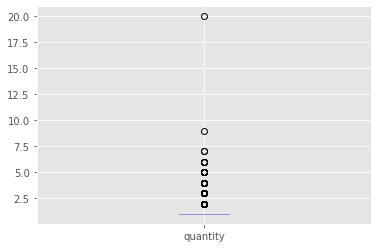

In [52]:
sales.boxplot(column=['quantity']);

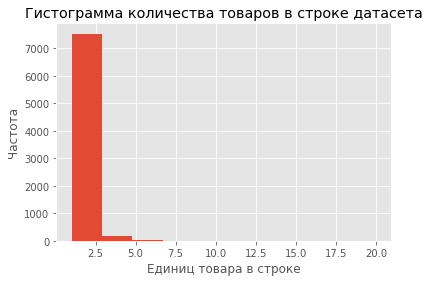

In [53]:
plt.title('Гистограмма количества товаров в строке датасета')
plt.xlabel('Единиц товара в строке')
plt.ylabel('Частота')
plt.hist(sales['quantity'], bins=10);

Очевидно, что количество единиц товара от 3 и более настолько редки, что их следует рассматривать, как выбросы. Оставим в датасете только те продажи, количество единиц товара в которых меньше 3.

In [54]:
sales = sales[sales['quantity'] < 3]

Просуммируем количество проданных единиц товара по дням, затем ресемплируем по среднему за неделю, и построим график.

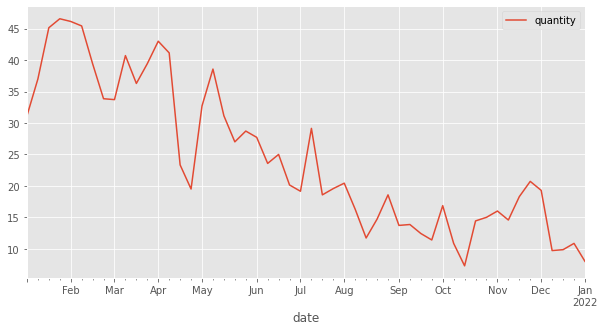

In [55]:
sales.pivot_table(index=('date'),\
                            values=('quantity'), aggfunc='sum').resample('1W').mean()\
                .plot(grid=True, figsize=(10, 5),style='-');

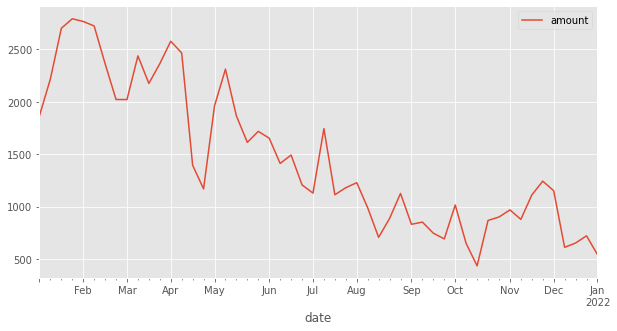

In [56]:
sales.pivot_table(index=('date'),\
                            values=('amount'), aggfunc='sum')\
                            .resample('1W').mean()\
                .plot(grid=True, figsize=(10, 5),style='-');

Судя по графикам очевидна зависимость между 'amount' и 'quantity'.

## Таблица `stocks_on_days`

In [57]:
stocks_on_days.columns

Index(['date', 'stock_id', 'item_id', 'start_day', 'finish_day'], dtype='object')

В датасете `sales` наблюдения начинаются 2021-01-04:

In [58]:
min(sales['date'])

Timestamp('2021-01-04 00:00:00')

Поэтому из `stocks_on_days` мы удалим все записи до этой даты.

In [59]:
stocks_on_days = stocks_on_days[stocks_on_days['date'] >= '2021-01-04']

In [60]:
stocks_on_days.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3793 entries, 467 to 4259
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        3793 non-null   datetime64[ns]
 1   stock_id    3793 non-null   object        
 2   item_id     3793 non-null   object        
 3   start_day   3793 non-null   int64         
 4   finish_day  3793 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 177.8+ KB


In [61]:
stocks_on_days.describe()

,start_day,finish_day
count,3793.000000,3793.000000
mean,5.533087,5.557342
std,5.474001,5.469993
min,-2.000000,-2.000000
25%,1.000000,1.000000
50%,4.000000,4.000000
75%,8.000000,8.000000
max,45.000000,45.000000


Мы уже отмечали, что в датасете `stocks_on_days` присутствуют записи с отрицательным балансом. В среднем на складах присутствует около 5,5 единиц товара.

Построим график количества товара в среднем за неделю.

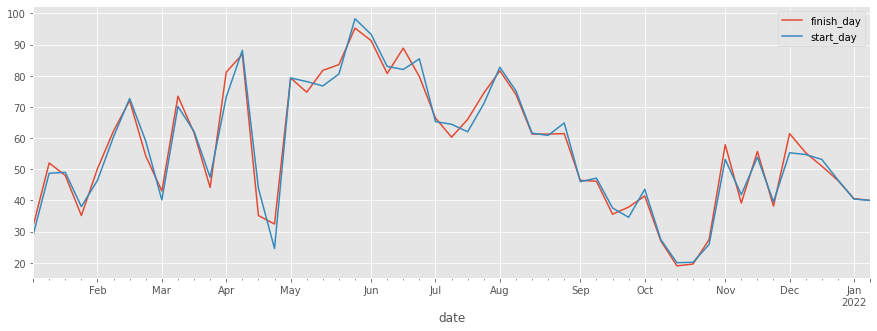

In [62]:
stocks_on_days.pivot_table(index=('date'),\
                            values=('start_day', 'finish_day'), aggfunc='sum').resample('1W').mean()\
                .plot(grid=True, figsize=(15, 5),style='-');

Товар появляется на складах в начале января 2021, в апреле наблюдается уменьшение количества единиц товара, в июне наблюдается пик количества, к октябрю товар раскупают быстрее, чем пополняют склады. Затем количество увеличивается и колеблется в диапозоне 40-60 шт. до конца наблюдений.

Посмотрим, какое количество товара в среднем лежит на разных складах.

In [63]:
# Функция строит горизонтальный бар по сводной таблице
def grouped_barh(df, index, value, aggfunc, title, xlabel, ylabel, top=50):
    df.pivot_table(index=index,\
                                values=value, aggfunc=aggfunc).sort_values(by=value, ascending=False)\
                                .head(top)\
                                .plot(kind='barh', grid=True, figsize=(10, 10))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

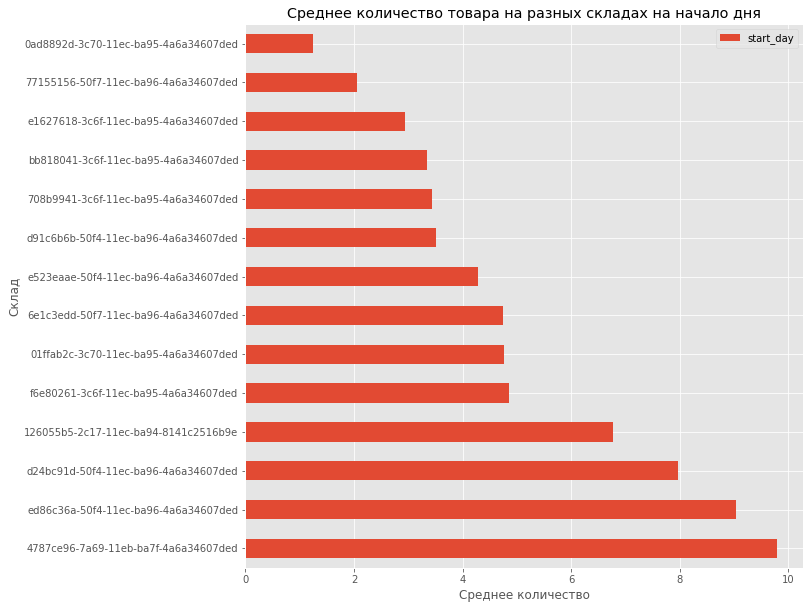

In [64]:
grouped_barh(stocks_on_days, 'stock_id', 'start_day', 'mean', \
             'Среднее количество товара на разных складах на начало дня', 'Среднее количество', 'Склад')

Эта информация может косвенно говорить о том, насколько велик склад (или точка магазина), либо о популярности данного товара в разных районах/городах/регионах.

# Исследовательский анализ данных

В дальнейшем мы скорее всего будем работать только с зависимостью количества продаж в день от времени. Но на данном этапе исследуем обе таблицы `sales_q` и `stocks_on_days_q`.

In [65]:
sales_q = sales.drop(columns=['warehouse_id', 'item_id', 'order_number', 'price', 'amount', 'sebes'])

In [66]:
sales_q = sales_q.groupby('date').sum()
sales_q

,quantity
date,
2021-01-04,9
2021-01-05,35
2021-01-06,30
2021-01-07,33
2021-01-08,38
...,...
2021-12-26,11
2021-12-27,7
2021-12-28,6


In [67]:
stocks_on_days.groupby('date').sum()

,start_day,finish_day
date,,
2021-01-04,0,20
2021-01-05,20,45
2021-01-06,45,23
2021-01-07,23,47
2021-01-08,47,20
...,...,...
2022-01-05,40,40
2022-01-06,40,40
2022-01-07,40,40


Так как графики 'start_day', 'finish_day' в `stocks_on_days` похожи, оставим для анализа только 'finish_day'. Таким образом мы получим информацию о количестве единиц товара, оставшихся на складах после завершения продаж (и поставок) в этот же день. Если бы мы оставили 'start_day', это бы по сути соответствовала результату продаж на предыдущий день. 

In [68]:
stocks_on_days_q = stocks_on_days.drop(columns=['stock_id', 'item_id', 'start_day'])

In [69]:
stocks_on_days_q = stocks_on_days_q.groupby('date').sum()
stocks_on_days_q

,finish_day
date,
2021-01-04,20
2021-01-05,45
2021-01-06,23
2021-01-07,47
2021-01-08,20
...,...
2022-01-05,40
2022-01-06,40
2022-01-07,40


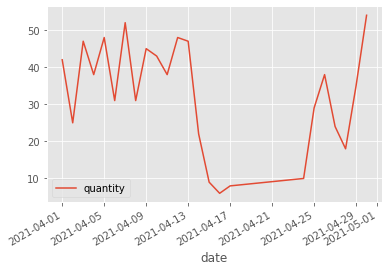

In [70]:
sales_q.loc['2021-04'].plot();

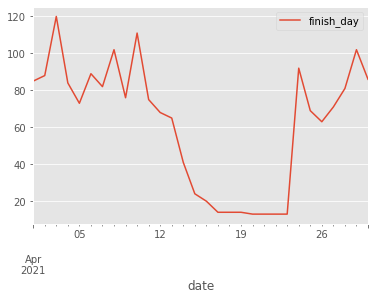

In [71]:
stocks_on_days_q.loc['2021-04'].plot();

Можно предположить, что снижение количества продаж в апреле было связано с проблемами с поставками на склады.

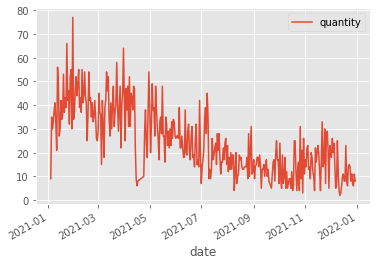

In [72]:
sales_q.plot();

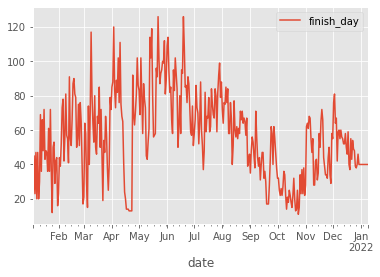

In [73]:
stocks_on_days_q.plot();

Итак, у нас есть два временных ряда, но если попытаться разложить один из них (`sales_q`) на аддитивные компоненты, то возникает ошибка:
ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None.

Эту ошибку можно легко устранить, вручную задав частоту сезонной составляющей. Логично предположить, что когда работаешь с датасетом продаж, обычно должна присутствовать недельная сезонность. Попробуем сначала разложить на аддитивные компоненты временной ряд `stocks_on_days_q`.

In [74]:
stocks_on_days_q = stocks_on_days_q.squeeze().dropna()

In [75]:
components_sod = tsa.seasonal_decompose(stocks_on_days_q, model='additive')

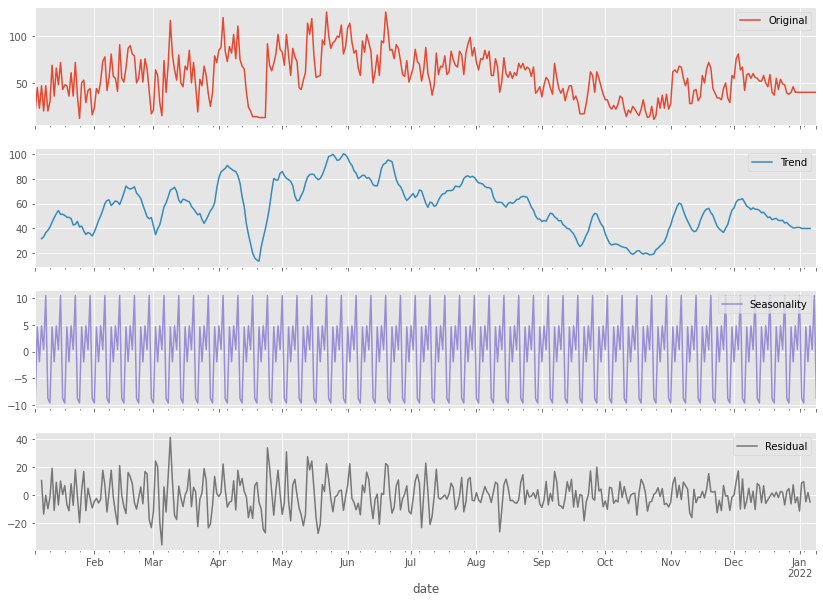

In [76]:
stocks_on_days_ts = (stocks_on_days_q.to_frame('Original')
      .assign(Trend=components_sod.trend)
      .assign(Seasonality=components_sod.seasonal)
      .assign(Residual=components_sod.resid))
stocks_on_days_ts.plot(subplots=True, figsize=(14, 10));

Код выполнился без ошибок и задания периода вручную. Посмотрим на первые несколько значений сезонной составляющей, чтобы оценить период.

In [77]:
components_sod.seasonal.head(22)

date
2021-01-04    -9.618561
2021-01-05     4.634186
2021-01-06    -1.904276
2021-01-07     4.837742
2021-01-08     0.356713
2021-01-09    10.485834
2021-01-10    -8.791638
2021-01-11    -9.618561
2021-01-12     4.634186
2021-01-13    -1.904276
2021-01-14     4.837742
2021-01-15     0.356713
2021-01-16    10.485834
2021-01-17    -8.791638
2021-01-18    -9.618561
2021-01-19     4.634186
2021-01-20    -1.904276
2021-01-21     4.837742
2021-01-22     0.356713
2021-01-23    10.485834
2021-01-24    -8.791638
2021-01-25    -9.618561
Name: seasonal, dtype: float64

Очевидно, период равен 7. Теперь вручную зададим период для временного ряда количества продаж.

In [78]:
sales_q = sales_q.squeeze().dropna()

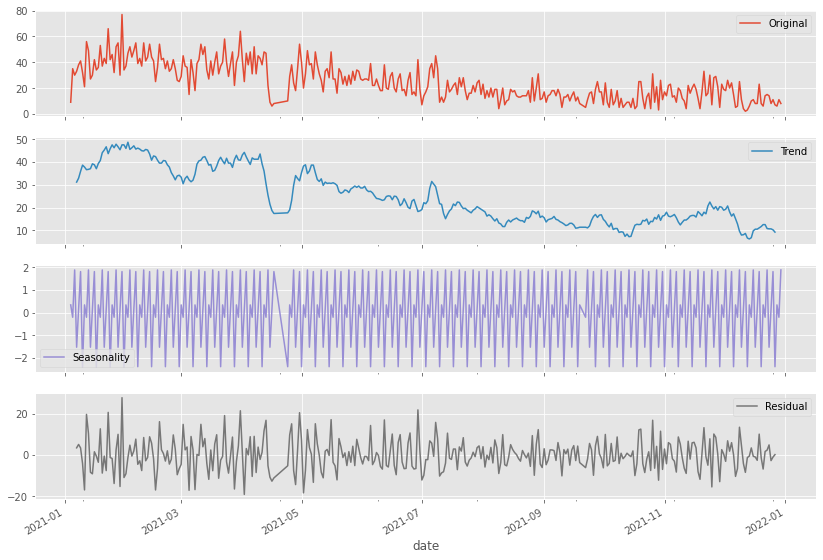

In [79]:
components_s = tsa.seasonal_decompose(sales_q, model='additive', period = 7) #freq = 7)
sales_ts = (sales_q.to_frame('Original')
      .assign(Trend=components_s.trend)
      .assign(Seasonality=components_s.seasonal)
      .assign(Residual=components_s.resid))
sales_ts.plot(subplots=True, figsize=(14, 10));

Понятно, что эти ряды не стационарны, т.к. присутствуют и тренд, и сезонность. Убедимся в этом, проведя тест Дикки-Фуллера.

In [80]:
def DF_test(series):
    """
    Расширенный тест Дикки-Фуллера (augmented Dickey-Fuller), ADF
    H0 - образец временного ряда имеет единичный корень
    H1 - образец временного ряда не имеет единичных корней, ряд стационарен
    """
    X = series.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0]> result[4]['5%']: 
        print('есть единичные корни, ряд не стационарен')
    else:
        print('единичных корней нет, ряд стационарен')

In [81]:
DF_test(stocks_on_days_q)

ADF Statistic: -2.187185
p-value: 0.210929
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
есть единичные корни, ряд не стационарен


In [82]:
DF_test(sales_q)

ADF Statistic: -1.586683
p-value: 0.490280
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
есть единичные корни, ряд не стационарен


Для того, чтобы построить прогноз, нам нужно удовлетворить допущение о стационарности линейных моделей временных рядов. Воспользуемся общепринятыми преобразованиями.

Сначала применим логарифм (натуральный) к временным рядам для конвертирования регулярности экспоненциального роста в линейный тренд и стабилизации дисперсии.

In [83]:
# проверка на нулевые значения
(sales_q == 0).any(), (stocks_on_days_q == 0).any()

(False, False)

In [84]:
sales_log = np.log(sales_q)
stocks_on_days_log = np.log(stocks_on_days_q)

Во многих случаях для того, чтобы сделать ряд стационарным, детрендирования не достаточно. Вместо этого нам нужно преобразовать исходные данные во временной ряд попериодных и/или посезонных разниц. Другими словами, мы используем результат вычитания соседних точек данных или значений в сезонных сдвигах друг из друга.

In [85]:
sales_diff = sales_q.diff().dropna() # первые разности
sales_log_diff = sales_log.diff().dropna() # первые разности из логарифма
sales_log_diff_s = sales_log.diff(7).dropna() # сезонные разности из логарифма
sales_diff_s = sales_q.diff(7).dropna() # сезонные разности

stocks_on_days_diff = stocks_on_days_q.diff().dropna() # первые разности
stocks_on_days_log_diff = stocks_on_days_log.diff().dropna() # первые разности из логарифма
stocks_on_days_log_diff_s = stocks_on_days_log.diff(7).dropna() # сезонные разности из логарифма

Изобразим на графике сразу несколько вариантов преобразований.

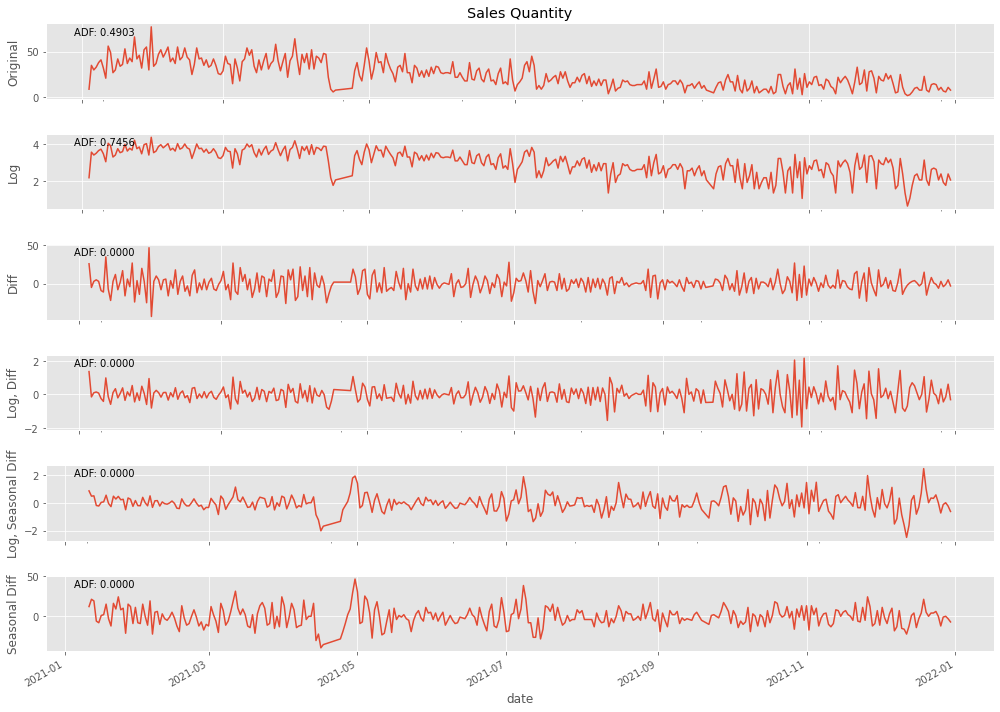

In [86]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(14,10))

sales_q.plot(ax=axes[0], title='Sales Quantity')
axes[0].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(sales_q.dropna())[1]:.4f}', transform=axes[0].transAxes)
axes[0].set_ylabel('Original')

sales_log.plot(ax=axes[1], sharex=axes[0])
axes[1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(sales_log.dropna())[1]:.4f}', transform=axes[1].transAxes)
axes[1].set_ylabel('Log')

sales_diff.plot(ax=axes[2], sharex=axes[0])
axes[2].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(sales_diff.dropna())[1]:.4f}', transform=axes[2].transAxes)
axes[2].set_ylabel('Diff')

sales_log_diff.plot(ax=axes[3], sharex=axes[0])
axes[3].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(sales_log_diff.dropna())[1]:.4f}', transform=axes[3].transAxes)
axes[3].set_ylabel('Log, Diff')

sales_log_diff_s.plot(ax=axes[4], sharex=axes[0])
axes[4].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(sales_log_diff_s.dropna())[1]:.4f}', transform=axes[4].transAxes)
axes[4].set_ylabel('Log, Seasonal Diff')

sales_diff_s.plot(ax=axes[5], sharex=axes[0])
axes[5].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(sales_diff_s.dropna())[1]:.4f}', transform=axes[5].transAxes)
axes[5].set_ylabel('Seasonal Diff')

#stocks_on_days_q.plot(ax=axes[0][1], title='Stocks on Days Quantity')
#axes[0][1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(stocks_on_days_q)[1]:.4f}', transform=axes[0][1].transAxes)
#axes[0][1].set_ylabel('Original')
#
#stocks_on_days_log.plot(ax=axes[1][1], sharex=axes[0][1])
#axes[1][1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(stocks_on_days_log.dropna())[1]:.4f}', transform=axes[1][1].transAxes)
#axes[1][1].set_ylabel('Log')
#
#stocks_on_days_diff.plot(ax=axes[2][1], sharex=axes[0][1])
#axes[2][1].text(x=.83, y=.85, s=f'ADF: {tsa.adfuller(stocks_on_days_diff.dropna())[1]:.4f}', transform=axes[2][1].transAxes)
#axes[2][1].set_ylabel('Diff')
#
#stocks_on_days_log_diff.plot(ax=axes[3][1], sharex=axes[0][1])
#axes[3][1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(sales_log_diff.dropna())[1]:.4f}', transform=axes[3][1].transAxes)
#axes[3][1].set_ylabel('Log, Diff')
#
#stocks_on_days_log_diff_s.plot(ax=axes[4][1], sharex=axes[0][1])
#axes[4][1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(stocks_on_days_log_diff_s.dropna())[1]:.4f}', transform=axes[4][1].transAxes)
#axes[4][1].set_ylabel('Log, Seasonal Diff')

fig.tight_layout()
fig.align_ylabels(axes);

Остановимся на варианте "Diff". Ещё раз проведём тест Дикки-Фуллера.

In [87]:
DF_test(sales_diff)

ADF Statistic: -10.756183
p-value: 0.000000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
единичных корней нет, ряд стационарен


Мы убедились, что наш ряд стационарен. Построим графики Q-Q и коррелограммы.

In [88]:
def plot_correlogram(x, lags=None, title=None):    
    """
    Строит Q-Q plot (от нормального распределения) и коррелограммы.
    Выводит некоторые статистики:
    Q-Stat: статистический показатель Льюнга-Бокса
    ADF: p-value расширенной проверки Дикки-Фуллера
    Mean: среднее
    SD: стандартное отклонение
    Skew: коэффициент асимметрии
    Kurtosis: эксцесс
    """
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes) 
    probplot(x, dist='norm', plot=axes[0][1])
    """
    Skew - https://ru.wikipedia.org/wiki/Коэффициент_асимметрии
    Kurtosis - https://ru.wikipedia.org/wiki/Коэффициент_эксцесса
    """
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


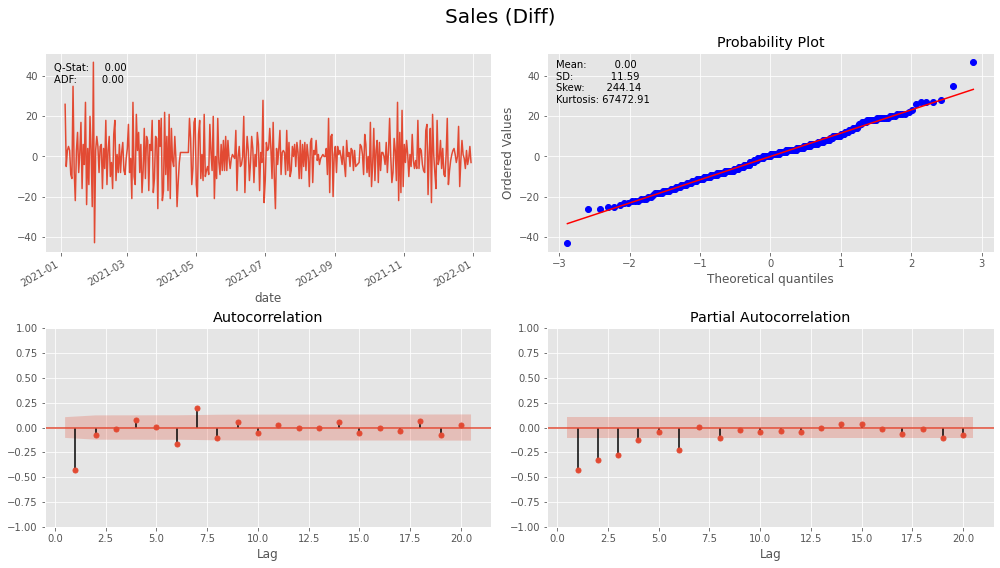

In [89]:
plot_correlogram(sales_diff, lags=20, title='Sales (Diff)')

Мы видим, что точки на графике Q-Q Plot стелятся вдоль прямой, соответствующей нормальному распределению. То есть можем сделать вывод о том, что наши данные неплохо соответствуют теоретическим квантилям, отложенным по горизонтальной оси. Хвосты нашего распределения уходят в разные стороны от прямой на графике Q-Q, что говорит о более толстых хвостах нашего распределения по сравнению с нормальным. 

Так как перед нами стоит задача прогнозирования продаж на неделю (или 7 дней) вперёд без каких-либо ещё вводных данных (например, известного количества товара, предполагаемого к поставке на определённый день), нам нужно строить модель, для которой на первый день из прогнозируемой недели будут все данные, необходимые для пргноза. Поэтому мы будем строить одномерную модель, то есть модель, целиком зависящую от значений продаж в прошлом.

# Модель SARIMAX

Воспользуемся моделью SARIMA, построенной для ряда первых разностей.
SARIMA(p,d,q)(P,D,Q,s) - Seasonal Autoregression Moving Average model.
Итак, чтобы построить модель нам нужно определить следующие параметры:
1. Порядок (order)
    - p — порядок авторегрессии тренда
    - d — порядок разности тренда
    - q — порядок скользящей средней тренда
2. Сезонный порядок(seasonal_order)
    - P — порядок авторегрессии для сезонного компонента
    - D — порядок разности ряда для сезонного компонента
    - Q — порядок скользящей средней для сезонного компонента
    - s — количество временных шагов за один сезонный период

Есть различные способы определения коэффициентов. Можно пользоваться правилами подбора коэффициентов в зависимости от значимых лагов, а можно сделать подобие своего собственного Grid Search для подбора гиперпараметров.

## Разработка Grid Search для модели SARIMAX

Для моделирования будем использовать модель SARIMA из библиотеки statsmodels

Эта модель имеет следующие гиперпараметры:

1. order: кортеж p, d и q для моделирования тренда.
2. sesonal_order: кортеж параметров P, D, Q и m для моделирования сезонности
3. trend: параметр для управления моделью, принимающий одно из следующих значений: 
    - 'n' - no trend,
    - 'c - constant,
    - 't' - linear trend,
    - 'ct' - constant with linear trend

Начнём с того, что определим функцию, которая будет принимать на вход конфигурацию модели и делать прогноз на один шаг вперёд.

In [245]:
# SARIMA-прогноз на шаг вперёд
def sarima_forecast(history, config, plot_diagnostics=False):
    # определяем конфигурацию модели: [(p, d, q), (P, D, Q, s), 'n']
    order, sorder, trend = config
    # определяем модель
    model = tsa.statespace.SARIMAX(history, 
                    order=order, 
                    seasonal_order=sorder, 
                    trend=trend, 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    # обучаем модель
    model_fit = model.fit(disp=False)
    # делаем прогноз на шаг вперед
    prediction = model_fit.predict(len(history), # номер с которого начинаем предсказывать
                                   len(history) # до какого номера предсказываем
                                  )
    if plot_diagnostics:
        model_fit.plot_diagnostics(figsize=(15, 12)) # диагностика остатков модели
    else:
        return prediction[0]

Теперь напишем функции для реализации walk-forward валидации.

Сначала напишем свою функцию разбиения `series_train_test_split()`. В качестве параметров будем использовать список или массив данных временного ряда, а в качестве метки разбиения будем указывать количество шагов с конца временного ряда, которое отведём под тестовый набор.

In [246]:
# разбиваем датасет на train и test наборы
def series_train_test_split(data, n_test):
    """
    Функция разделяет список или массив на тренировочный и тестовый наборы данных.
    n_test - количество временных шагов с конца, используемых в тестовом (валидационном) наборе.
    """
    return data[:-n_test], data[-n_test:]

In [247]:
# проверка
series_train_test_split(sales_diff.head(8), 3)

(date
 2021-01-05    26.0
 2021-01-06    -5.0
 2021-01-07     3.0
 2021-01-08     5.0
 2021-01-09     3.0
 Name: quantity, dtype: float64, date
 2021-01-10    -9.0
 2021-01-11   -11.0
 2021-01-12    35.0
 Name: quantity, dtype: float64)

Будем использовать RMSE как метрику качества.

In [248]:
def rmse(y_true,y_pred):
    rmse = mean_squared_error(y_true, y_pred)**(0.5)
    return rmse

Теперь реализуем walk-forward валидацию. 

In [249]:
# walk-forward validation
def walk_forward_validation(data, # наш временной ряд
                            n_test, # количество шагов с конца data, с которого начинаем валидировать 
                            model_forecast, # имя функции прогноза
                            config, # конфигурация модели SARIMA
                            plot=False, # можем построить график сравнения predictions и test
                            plot_resid=False # графики остатков
                           ):
    predictions = list()
    # разделяем датасет
    train, test = series_train_test_split(data, n_test)
    # помещаем train в список исторических данных history
    history = [x for x in train]
    # проходимся по каждому из значений в тестовом наборе
    for i in range(len(test)):
        # обучаем модель на исторических данных и делаем прогноз на шаг вперед
        #prediction = sarima_forecast(history, config)
        prediction = model_forecast(history, config)
        # сохраняем предсказание в список предсказаний
        predictions.append(prediction)
        # действительное значение помещаем в историю для следующего цикла
        history.append(test[i])
    # вычисляем ошибку предсказания сравнивая все одношаговые предсказания с реальными значениями
    error = rmse(test, predictions)
    #print(len(predictions))
    #print(len(test))
    #print(len(train))
    #print(len(history))
    if plot:
        # график для визуального сравнения предсказанных значений с действительными
        # (по умолчанию не строим)
        plot_result(n_test, error, test, predictions)
    if plot_resid:
        # график остатков 
        model_forecast(test.asfreq('D'), config, True)
    else:
        # по умолчанию возвращаем интересующую метрику качества 
        return error

In [95]:
# график для визуальной оценки
def plot_result(n_test, error, test, predictions):
    """
    Строит график сравнения предсказанных на каждом шаге
    значений с действительными значениями
    """
    test = pd.DataFrame(test.values, index=sales_diff.tail(n_test).index, columns=['actual'])
    predictions = pd.DataFrame(predictions, index=sales_diff.tail(n_test).index, columns=['predictions'])
    ax = test.plot(figsize=(15,6), color='black', title='actual VS predictions')
    metric = f'RMSE: {error:>.3f}'
    ax.text(x=.02, y=.95, s=metric, transform=ax.transAxes)
    predictions.plot(ax=ax, style='--', color='green')
    ax.legend(loc='lower right')
    plt.show();

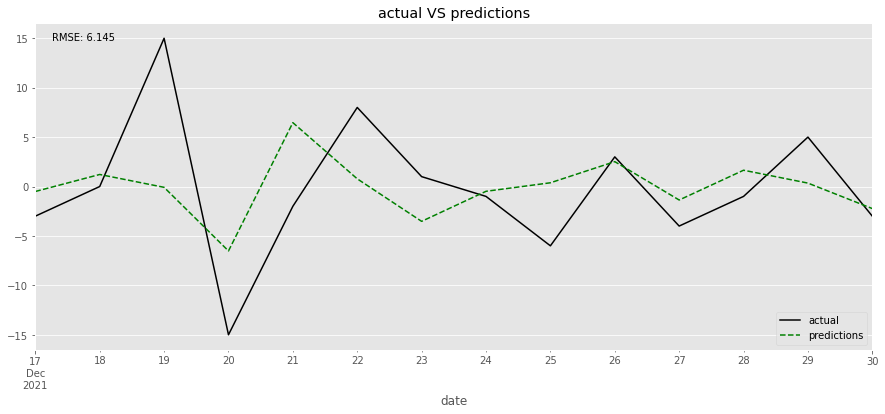

6.145343339369119

In [250]:
# проверка работы функции
walk_forward_validation(sales_diff, 14, sarima_forecast, [(1, 1, 1), (0, 0, 0, 0), 'n'], plot=True, plot_resid=False)

Мы можем неоднократно вызывать `walk_forward_validation()` с различными списками конфигураций моделей.

Одна из возможных проблем заключается в том, что некоторые комбинации конфигураций модели могут не вызываться для модели и выдавать исключение, например, указывая некоторые, но не все аспекты сезонной структуры в данных.

Мы можем ловить исключения и игнорировать предупреждения во время поиска в сетке, обернув все вызовы walk_forward_validation() try-except блоком для игнорирования предупреждений. Мы также можем добавить поддержку отладки, чтобы отключить эти средства защиты в случае, если мы хотим увидеть, что на самом деле происходит. Наконец, если ошибка все же возникает, мы можем вернуть результат None, в противном случае мы сможем напечатать некоторую информацию о каждой оцениваемой модели. Это полезно при оценке большого количества моделей.

Функция score_model() ниже реализует это и возвращает кортеж (ключ и результат), где ключ является строковой версией протестированной конфигурации модели.

In [251]:
# оцениваем модель возвращаем None при возникновении ошибки
def score_model(data, n_test, config, debug=False):
    result = None
    # конвертируем конфигурацию в строковый ключ
    key = str(config)
    # показываем все предупреждения, если debug=True
    if debug:
        result = walk_forward_validation(data, n_test, sarima_forecast, config)
    else:
        # сбой во время проверки модели предполагает нестабильную конфигурацию
        try:
            # во время поиска по сетке не показываем предупреждения
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, sarima_forecast, config)
        except:
            error = None
    # проверяем на наличие интересующего результата
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [252]:
# проверка
score_model(sales_diff, 8, [(4, 1, 1), (0, 0, 0, 0), 'n'], debug=False)[1]

 > Model[[(4, 1, 1), (0, 0, 0, 0), 'n']] 3.004


3.0040426776882403

Далее нам нужен цикл для тестирования списка различных конфигураций моделей.

Это основная функция, которая управляет процессом поиска по сетке и вызывает функцию `score_model()` для каждой конфигурации модели.

Мы можем значительно ускорить процесс поиска по сетке, параллельно оценивая конфигурации моделей. Один из способов сделать это - использовать библиотеку Joblib.

Мы можем определить параллельный объект с количеством используемых ядер и установить его на количество ядер, обнаруженных в оборудовании.

In [99]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

In [253]:
def grid_search(data, 
                config_list, # список всех конфигураций
                n_test, 
                parallel=False):
    scores = None
    if parallel:
        # определяем количество используемых ядер
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        print(executor)
        # создаём список задач для параллельного выполнения
        tasks = (delayed(score_model)(data, n_test, config) for config in config_list)
        print(tasks)
        # передаём задачи в executor
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, config) for config in config_list]
    # удаляем пустые результаты
    scores = [r for r in scores if r[1] != None]
    # сортируем кортежи в списке по баллу в порядке возрастания (сначала лучше всего)
    scores.sort(key=lambda tup: tup[1])
    return scores

In [101]:
# проверка
grid_search(sales_diff, [[(1, 0, 0), (0, 0, 0, 0), 'n'], [(1, 0, 0), (0, 5, 0, 0), 'n']], 7, parallel=False)

 > Model[[(1, 0, 0), (0, 0, 0, 0), 'n']] 3.342


[("[(1, 0, 0), (0, 0, 0, 0), 'n']", 3.342422124758878)]

Осталось только определить список конфигураций модели, которые можно попробовать для набора данных.
Мы можем определить его в общем виде. Единственный параметр, который мы, возможно, захотим указать, это периодичность сезонного компонента в серии, если таковой существует. По умолчанию мы не будем считать сезонных компонентов.

Функция `sarima_configs()` ниже создаст список конфигураций моделей для оценки.

Конфигурации предполагают, что каждый из компонентов AR, MA и I для тренда и сезонности имеет низкий порядок, например, выключен (0) или в [1,2]. 

Теоретически, существует 2880 возможных конфигураций модели для оценки, но на практике многие из них не будут действительными и приведут к ошибке, которую мы поймаем и проигнорируем.

In [242]:
# задаем конфигурации sarima
def sarima_configs(seasonal=[0]):
    models = list()
    # определяем параметры
    p_params = [1, 2, 3, 4]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P__params = [0, 1, 2, 3, 4]
    D__params = [0, 1]
    Q__params = [0, 1, 2]
    s_params = seasonal
    # сохраняем в список
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P_ in P__params:
                        for D_ in D__params:
                            for Q_ in Q__params:
                                for s in s_params:
                                    config = [(p,d,q), (P_,D_,Q_,s), t]
                                    models.append(config)
    return models

In [243]:
len(sarima_configs())

2880

## Выбор лучшей конфигурации для модели SARIMAX

Теперь у нас есть структура для поиска гиперпараметров модели SARIMA.

Он является универсальным и будет работать для любых одномерных временных рядов, предоставленных в виде списка или массива NumPy.

In [254]:
%%time
if __name__ == '__main__':
    # загружаем датасет
    print('Всего объектов в ряде:', sales_diff.shape[0])
    # размер выборки для walk-forward валидации
    n_test = round(len(sales_diff)*0.2)
    print('Объектов в тестовой выборке:', n_test)
    # конфигурация модели
    config_list = sarima_configs()
    # grid search
    scores = grid_search(sales_diff, config_list, n_test)
    print('Лучшие модели:')
    # топ-3 конфигурации
    for config, error in scores[:3]:
        print(config, error)

Всего объектов в ряде: 352
Объектов в тестовой выборке: 70
 > Model[[(1, 0, 0), (0, 0, 0, 0), 'n']] 9.134
 > Model[[(1, 0, 0), (0, 0, 0, 0), 'c']] 9.148
 > Model[[(1, 0, 0), (0, 0, 0, 0), 't']] 9.177
 > Model[[(1, 0, 0), (0, 0, 0, 0), 'ct']] 9.192
 > Model[[(1, 0, 1), (0, 0, 0, 0), 'n']] 7.828
 > Model[[(1, 0, 1), (0, 0, 0, 0), 'c']] 8.311
 > Model[[(1, 0, 1), (0, 0, 0, 0), 't']] 8.055
 > Model[[(1, 0, 1), (0, 0, 0, 0), 'ct']] 8.412
 > Model[[(1, 0, 2), (0, 0, 0, 0), 'n']] 8.243
 > Model[[(1, 0, 2), (0, 0, 0, 0), 'c']] 8.478
 > Model[[(1, 0, 2), (0, 0, 0, 0), 't']] 8.369
 > Model[[(1, 0, 2), (0, 0, 0, 0), 'ct']] 8.527
 > Model[[(1, 1, 0), (0, 0, 0, 0), 'n']] 13.599
 > Model[[(1, 1, 0), (0, 0, 0, 0), 'c']] 13.622
 > Model[[(1, 1, 0), (0, 0, 0, 0), 't']] 13.666
 > Model[[(1, 1, 0), (0, 0, 0, 0), 'ct']] 13.687
 > Model[[(1, 1, 1), (0, 0, 0, 0), 'n']] 9.146
 > Model[[(1, 1, 1), (0, 0, 0, 0), 'c']] 9.190
 > Model[[(1, 1, 1), (0, 0, 0, 0), 't']] 9.441
 > Model[[(1, 1, 1), (0, 0, 0, 0), 'ct']

Итак, лучшая модель SARIMA имеет параметры [(4, 0, 1), (0, 0, 0, 0), 'n']. Оценим остатки модели. Для этого возьмём хотя бы 30 точек.

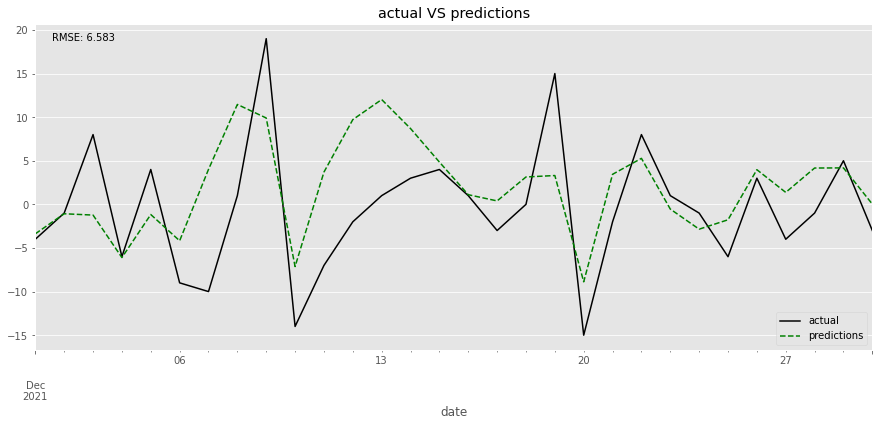

6.583204858236249

In [105]:
walk_forward_validation(sales_diff, 30, sarima_forecast, [(4, 0, 1), (0, 0, 0, 0), 'n'], plot=True)

Судя по построенным графикам распределение остатков приближено к нормальному.

Так как нам в итоге нужно построить прогноз на неделю вперед, будем оценивать эту модель и сравнивать её по качеству с другими моделями метрикой RMSE за последнюю неделю.

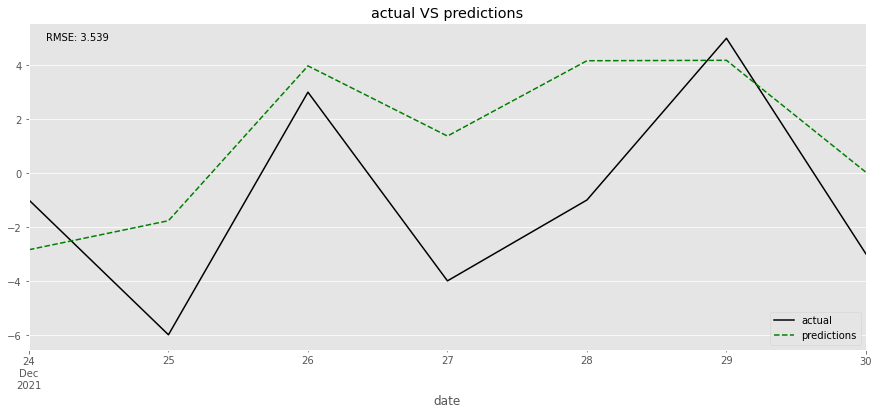

3.5387752704318687

In [106]:
walk_forward_validation(sales_diff, 7, sarima_forecast, [(4, 0, 1), (0, 0, 0, 0), 'n'], plot=True, plot_resid=False)

Мы построили модель SARIMA, теперь посмотрим, как распределены остатки модели. Судя по построенным графикам распределение остатков приближено к нормальному.

# Градиентный бустинг CatBoost

## Подготовка признаков

Мы можем реструктурировать последовательность временного ряда так, чтобы данные на входе в модель выглядели как задача обучения с учителем. Мы можем сделать это, используя предыдущие временные шаги в качестве входных переменных и используя следующий временной шаг в качестве выходной переменной. Попробуем добавить в качестве признаков также месяц, номер недели и день недели.

In [255]:
def make_features(series, column, max_lag):
    """
    Функция создаёт признаки сдвига во времени (лаги)
    """
    data = pd.DataFrame(series, index=series.index)
    #data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    #data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[column+'_lag_{}'.format(lag)] = data[column].shift(lag)
    #data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()
    return data

In [256]:
data = make_features(sales_diff, 'quantity', 7)
data

,quantity,month,day,dayofweek,quantity_lag_1,quantity_lag_2,quantity_lag_3,quantity_lag_4,quantity_lag_5,quantity_lag_6,quantity_lag_7
date,,,,,,,,,,,
2021-01-05,26.0,1,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,-5.0,1,6,2,26.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,3.0,1,7,3,-5.0,26.0,NaN,NaN,NaN,NaN,NaN
2021-01-08,5.0,1,8,4,3.0,-5.0,26.0,NaN,NaN,NaN,NaN
2021-01-09,3.0,1,9,5,5.0,3.0,-5.0,26.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,3.0,12,26,6,-6.0,-1.0,1.0,8.0,-2.0,-15.0,15.0
2021-12-27,-4.0,12,27,0,3.0,-6.0,-1.0,1.0,8.0,-2.0,-15.0
2021-12-28,-1.0,12,28,1,-4.0,3.0,-6.0,-1.0,1.0,8.0,-2.0


## Подготовка функций

Проверим написанную нами функцию разбиения на тренировочную и тестовую выборки применительно к новым данным.

In [257]:
# проверка
train, test = series_train_test_split(data, 70)
print(train.shape)
print(test.shape)

(282, 11)
(70, 11)


Изменим функцию walk-forward валидации с учётом формата входных данных.

In [258]:
# walk-forward validation for CatBoost
def walk_forward_validation(data, n_test, target, config, plot=False):
    predictions = list()
    # разбиваем на train и test
    train, test = series_train_test_split(data, n_test)
    # помещаем train в историю
    history = train
    # проходимся по каждому из значений в тестовом наборе
    for i in range(len(test)):
        # выделяем признаки и целевой признак
        features_test, target_test = test.drop(columns=[target]).iloc[i], test[target].iloc[i]
        # обучаем модель на истории и делаем предсказание на шаг вперёд
        prediction = catboost_forecast(history, features_test, target, config)
        # сохраняем предсказание в список
        predictions.append(prediction)
        # добавляем действительное значение в историю
        history.append(test.iloc[i])
        # отслеживаем прогресс
        print('>expected=%.1f, predicted=%.1f' % (target_test, prediction))
    # вычисляем ошибку
    error = rmse(test[target], predictions)
    #return error, test[target], predictions
    if plot:
        # график для визуального сравнения предсказанных значений с действительными
        # (по умолчанию не строим)
        plot_result(n_test, error, test[target], predictions)
        # график остатков 
        #model_forecast(test.asfreq('D'), config, True)
    else:
        # по умолчанию возвращаем интересующую метрику качества 
        return error

Напишем функцию прогноза на один шаг вперед, который будет делать лучшая выбранная по сетке параметров модель градиентного бустинга из библиотеки CatBoost. 

In [259]:
# CatBoost-прогноз на шаг вперёд
def catboost_forecast(train, features_test, target, config):
    # определяем конфигурацию
    learning_rate, depth, l2_leaf_reg, iterations, task_type, verbose, random_seed = config
    # выделяем целевой признак из train
    features_train, target_train = train.drop(columns=[target]), train[target]
    # определяем модель
    model_CBR = CatBoostRegressor(learning_rate=learning_rate, 
                                  depth=depth, 
                                  l2_leaf_reg=l2_leaf_reg, 
                                  iterations=iterations, 
                                  task_type=task_type, 
                                  verbose=verbose,
                                  random_seed=random_seed,
                                  loss_function='RMSE')
    # осуществляем grid search, на выходе получаем лучшую обученную модель
    model_CBR.fit(features_train, target_train)
    # делаем прогноз на шаг вперед
    prediction = model_CBR.predict(features_test)
    return prediction

In [112]:
# проверка
#catboost_forecast(train, features_test.iloc[1], 'quantity', (0.01, 2, 1, 1000, 'CPU', 0, 12345))

In [260]:
# оцениваем модель и возвращаем None при возникновении ошибки
def score_model(data, n_test, target, config, debug=False):
    result = None
    # конвертируем конфигурацию в строковый ключ
    key = str(config)
    # показываем все предупреждения, если debug=True
    if debug:
        result = walk_forward_validation(data, n_test, target, config)
    else:
        # сбой во время проверки модели предполагает нестабильную конфигурацию
        try:
            # во время поиска по сетке не показываем предупреждения
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, target, config)
        except:
            error = None
    # проверяем на наличие интересующего результата
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [261]:
# проверка
score_model(data, 2, 'quantity', (0.01, 2, 1, 1000, 'CPU', 0, 12345), debug=False)

>expected=5.0, predicted=3.6
>expected=-3.0, predicted=3.3
 > Model[(0.01, 2, 1, 1000, 'CPU', 0, 12345)] 4.557


("(0.01, 2, 1, 1000, 'CPU', 0, 12345)", 4.556707122275873)

В библиотеке CatBoost есть штатная функция `grid_search()`, которая красиво визуализирует поиск по сетке, однако мы сделаем свою, чтобы затем можно было сравнить полученные результаты из разных типов моделей.

In [262]:
def grid_search(data, 
                n_test, 
                target,
                config_list, # список всех конфигураций
                parallel=False):
    scores = None
    if parallel:
        # определяем количество используемых ядер
        #executor = Parallel(n_jobs=cpu_count()-1, backend='multiprocessing', verbose=1)
        scores = Parallel(n_jobs=-1, backend='multiprocessing', verbose=1)(delayed(score_model)(data, n_test, target, config, debug=True) for config in config_list)
        #print(executor)
        # создаём список задач для параллельного выполнения
        #tasks = (delayed(score_model)(data, n_test, target, config) for config in config_list)
        #print(tasks)
        # передаём задачи в executor
        #scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, target, config) for config in config_list]
    # удаляем пустые результаты
    scores = [r for r in scores if r[1] != None]
    # сортируем кортежи в списке по баллу в порядке возрастания (сначала лучше всего)
    scores.sort(key=lambda tup: tup[1])
    return scores

Создадим список всех конфигураций гиперпараметров.

In [263]:
# создаем набор конфигураций гиперпараметров
def catboost_configs():
    models = list()
    # определяем гиперпараметры
    learning_rate = [0.01, 0.03, 0.1, 0.2, 0.3]
    depth = [2, 4, 6, 8, 10]
    l2_leaf_reg = [1, 3, 5, 7, 9]
    iterations = [1000]
    task_type = ['CPU']
    verbose = [0]
    random_seed = [12345]
    # заполняем список конфигураций
    for lr in learning_rate:
        for d in depth:
            for leaf in l2_leaf_reg:
                for i in iterations:
                    for t in task_type:
                        for v in verbose:
                            for r in random_seed:
                                config = lr,d,leaf,i,t,v,r
                                models.append(config)
    return models

In [117]:
# проверка
catboost_configs()[1]

(0.01, 2, 3, 1000, 'CPU', 0, 12345)

## Выбор лучшей конфигурации гиперпараметров для модели CatBoost

In [264]:
if __name__ == '__main__':
    n_test = 7
    target = 'quantity'
    config_list = catboost_configs()
    scores = grid_search(data, n_test, target, config_list, parallel=False)
    print('Лучшие модели:')
    # топ-3 конфигурации
    for config, error in scores[:3]:
        print(config, error)

>expected=-1.0, predicted=-2.2
>expected=-6.0, predicted=0.3
>expected=3.0, predicted=6.2
>expected=-4.0, predicted=1.3
>expected=-1.0, predicted=3.0
>expected=5.0, predicted=3.7
>expected=-3.0, predicted=3.1
 > Model[(0.01, 2, 1, 1000, 'CPU', 0, 12345)] 4.392
>expected=-1.0, predicted=-2.1
>expected=-6.0, predicted=0.4
>expected=3.0, predicted=6.0
>expected=-4.0, predicted=1.3
>expected=-1.0, predicted=2.8
>expected=5.0, predicted=3.3
>expected=-3.0, predicted=2.6
 > Model[(0.01, 2, 3, 1000, 'CPU', 0, 12345)] 4.272
>expected=-1.0, predicted=-1.8
>expected=-6.0, predicted=0.3
>expected=3.0, predicted=5.3
>expected=-4.0, predicted=1.1
>expected=-1.0, predicted=2.7
>expected=5.0, predicted=2.8
>expected=-3.0, predicted=1.6
 > Model[(0.01, 2, 5, 1000, 'CPU', 0, 12345)] 4.007
>expected=-1.0, predicted=-2.0
>expected=-6.0, predicted=0.1
>expected=3.0, predicted=5.2
>expected=-4.0, predicted=0.7
>expected=-1.0, predicted=2.3
>expected=5.0, predicted=2.4
>expected=-3.0, predicted=1.3
 > Model

>expected=-1.0, predicted=-1.8
>expected=-6.0, predicted=0.1
>expected=3.0, predicted=5.1
>expected=-4.0, predicted=0.8
>expected=-1.0, predicted=2.2
>expected=5.0, predicted=2.3
>expected=-3.0, predicted=1.0


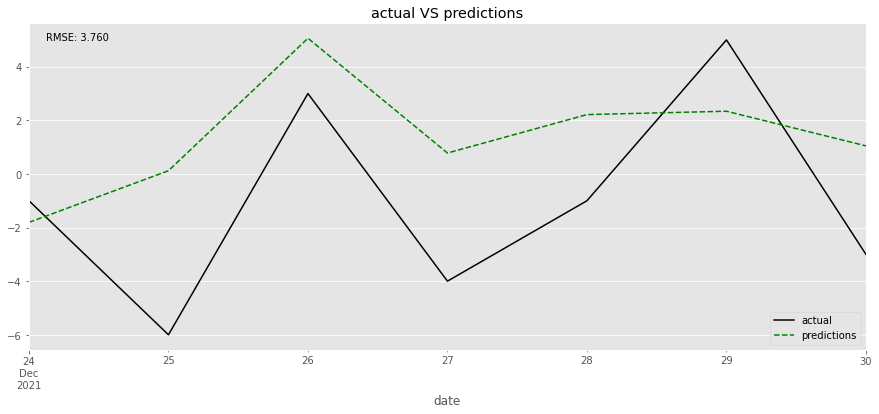

In [266]:
n_test = 7
target = 'quantity'
config = (0.01, 2, 9, 1000, 'CPU', 0, 12345)
walk_forward_validation(data, n_test, target, config, plot=True)

Мы построили модель CatBoost, однако в нашем случае она уступает модели SARIMA.

# Нейронная сеть для временного ряда

Такие нейронные сети обладают рядом особенностей:
- Устойчивость к шуму. Нейронные сети устойчивы к шуму во входных данных и могут поддерживать обучение и прогнозирование при наличии отсутствующих значений.
- Нелинейность. Нейронные сети способны аппроксимировать произвольные нелинейные функции и учитывать линейные и нелинейные отношения.
- Многомерные входы. Можно указать произвольное количество входных функций.
- Многоэтапные прогнозы. Можно указать произвольное количество выходных значений, обеспечивающее поддержку многоступенчатого и даже многомерного прогнозирования.
- Фиксированные входы. Количество входных переменных с задержкой фиксировано так же, как и традиционные методы прогнозирования временных рядов. 
- Выходные данные. Количество выходных переменных также фиксировано.

Рекуррентные нейронные сети, такие как сеть Long Short-Term Memory, добавляют явную обработку порядка между наблюдениями при изучении функции отображения от входов к выходам.

Добавление последовательности является новым измерением к аппроксимируемой функции. Вместо того, чтобы сопоставлять входы только с выходами, сеть способна со временем изучать функцию сопоставления входов с выходом.

В простейшем случае сеть показывает по одному наблюдению за раз из последовательности и может узнать, какие наблюдения она видела ранее, актуальны лм они, и насколько они актуальны для прогнозирования.

Если для традиционных методов прогнозирования временных рядов обязательно наличие стационарности ряда, то для нейронных сетей стационарность может не быть обязательным требованием для построения хорошей модели.

## Vanilla LSTM

In [120]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

На вход модель LSTM принимает последовательность прошлых наблюдений. Преобразуем датасет соответствующим образом.

Оставим в качестве признаков только лаги.



In [121]:
data = data.drop(columns=['month', 'day', 'dayofweek'])
data

,quantity,quantity_lag_1,quantity_lag_2,quantity_lag_3,quantity_lag_4,quantity_lag_5,quantity_lag_6,quantity_lag_7
date,,,,,,,,
2021-01-05,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,-5.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,3.0,-5.0,26.0,NaN,NaN,NaN,NaN,NaN
2021-01-08,5.0,3.0,-5.0,26.0,NaN,NaN,NaN,NaN
2021-01-09,3.0,5.0,3.0,-5.0,26.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-12-26,3.0,-6.0,-1.0,1.0,8.0,-2.0,-15.0,15.0
2021-12-27,-4.0,3.0,-6.0,-1.0,1.0,8.0,-2.0,-15.0
2021-12-28,-1.0,-4.0,3.0,-6.0,-1.0,1.0,8.0,-2.0


В отличие от моделей из библиотеки CatBoost, которые по умолчанию удаляют NaN значения, на вход в LSTM нам нужно подать уже очищенные значения.

In [122]:
data = data.dropna()

Изменим функцию `walk_forward_validation()` применительно к модели LSTM.

In [123]:
# walk-forward validation for LSTM
def walk_forward_validation(data, n_test, target, config, plot=False):
    predictions = list()
    # разбиваем последовательность
    train, test = series_train_test_split(data, n_test)
    # сохраняем обучающую выборку в истории
    history = train
    # проходимся по каждому из значений в тестовой последовательности
    for i in range(len(test)):
        # выделяем признаки и целевой признак в тесте
        features_test, target_test = test.drop(columns=[target]).iloc[i], test[target].iloc[i]
        # обучаемся на истории и делаем предсказание на шаг вперёд
        prediction = lstm_forecast(history, features_test, target, config)
        # сохраняем предсказание в список
        predictions.append(prediction)
        # сохраняем действительное значение в историю
        history.append(test.iloc[i])
        # для отслеживания процесса на каждом шаге:
        print('>expected=%.1f, predicted=%.1f' % (target_test, prediction))#.iloc[0][0]))
    # вычисляем ошибку предсказаний
    error = rmse(test[target], predictions)
    #return error, test[target], predictions
    if plot:
        # график для визуального сравнения предсказанных значений с действительными
        # (по умолчанию не строим)
        plot_result(n_test, error, test[target], predictions)
        return error, test[target], predictions
    else:
        # по умолчанию возвращаем интересующую метрику качества 
        return error

Напишем функцию для одношагового прогноза при помощи LSTM.

In [124]:
config = (70, 'relu', 'adam', 'mse', 1, 270, 1)
# lstm-прогноз на шаг вперёд
def lstm_forecast(train, 
                  features_test, # строка признаков для валидаии
                  target, # имя колонки датафрейма целевого признака
                  config):
    # определяем конфигурацию
    units, activation, optimizer, loss, n_features, epochs, verbose = config
    # выделяем целевой признак из train
    features_train, target_train = train.drop(columns=[target]), train[target]
    # преобразуем датафреймы в объекты numpy (нам нужен определённый формат на входе в модель).
    features_train_arr = features_train.to_numpy()
    features_test_arr = features_test.to_numpy()
    target_train_arr = target_train.to_numpy()
    # Модель принимает тренировочные данные в таком формате: (samples, timesteps, features).
    # Изменим форму входных данных.
    n_steps = features_train_arr.shape[1]
    features_train_arr = features_train_arr.reshape((features_train.shape[0], n_steps, n_features))
    features_test_arr = features_test_arr.reshape((1, n_steps, n_features))
    # определяем модель
    model_vanilla_LSTM = Sequential()
    model_vanilla_LSTM.add(LSTM(units=units, activation=activation, input_shape=(n_steps, n_features)))
    model_vanilla_LSTM.add(Dense(1))
    model_vanilla_LSTM.compile(optimizer='adam', loss='mse')
    # обучаем модель, на выходе получаем обученную модель с минимальной MSE, следовательно, и RMSE
    model_vanilla_LSTM.fit(features_train_arr, target_train_arr, epochs=epochs, verbose=verbose)
    # делаем прогноз на шаг вперед
    prediction = model_vanilla_LSTM.predict(features_test_arr)
    #prediction = pd.DataFrame(prediction[0], columns=['prediction'], index=[features_test.name])
    #prediction = prediction.reshape((features_train.shape[0], n_steps))
    return prediction[0]

Так как обучение нейросети займёт значительное время, а из гиперпараметров мы будем менять разве что количество нейронов в скрытом слое и количество эпох, то функцию `grid_search()` специально писать не будем.

Epoch 1/270
11/11 [==============================] - 2s 5ms/step - loss: 136.0064
Epoch 2/270
11/11 [==============================] - 0s 5ms/step - loss: 133.3614
Epoch 3/270
11/11 [==============================] - 0s 5ms/step - loss: 130.2023
Epoch 4/270
11/11 [==============================] - 0s 6ms/step - loss: 121.9947
Epoch 5/270
11/11 [==============================] - 0s 5ms/step - loss: 102.7057
Epoch 6/270
11/11 [==============================] - 0s 5ms/step - loss: 91.6894
Epoch 7/270
11/11 [==============================] - 0s 5ms/step - loss: 99.5159
Epoch 8/270
11/11 [==============================] - 0s 5ms/step - loss: 96.3748
Epoch 9/270
11/11 [==============================] - 0s 5ms/step - loss: 85.4527
Epoch 10/270
11/11 [==============================] - 0s 7ms/step - loss: 88.9953
Epoch 11/270
11/11 [==============================] - 0s 5ms/step - loss: 86.2955
Epoch 12/270
11/11 [==============================] - 0s 5ms/step - loss: 81.7419
Epoch 13/270
11/11 [

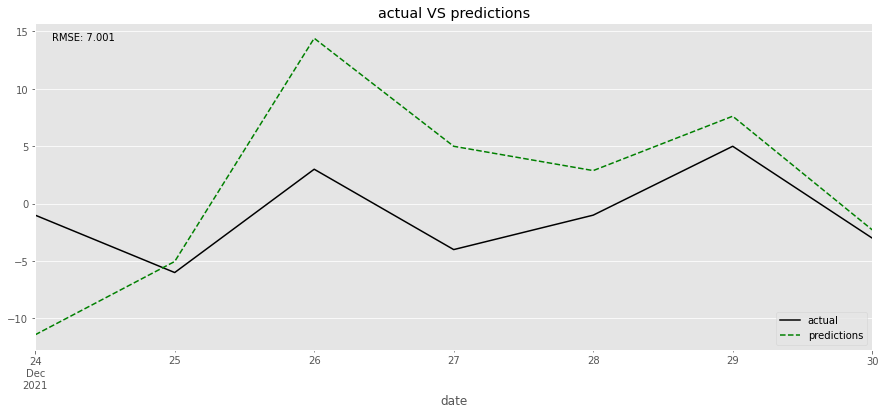

In [125]:
error_stckd, val, pred_stckd = walk_forward_validation(data, 7, 'quantity', config, plot=True)

В нашем случае мы определили модель с 70 единицами LSTM в скрытом слое и выходным слоем, который предсказывает одно числовое значение.

Обучилась модель с использованием эффективной версии стохастического градиентного спуска 'adam' и функцией потерь RMSE.

## Stacked LSTM

Несколько скрытых слоев LSTM могут быть сложены друг на друга в так называемой модели Stacked LSTM. 

Уровень LSTM требует трехмерного ввода, и LSTM по умолчанию будет возвращать двумерный вывод.

Мы можем решить эту проблему, установив аргумент return_sequences=True на слое. Это позволяет нам иметь 3D-выход со скрытого слоя LSTM в качестве входных данных на следующий.

Изменим функцию `lstm_forecast` задав модель Stacked LSTM.

In [126]:
config = (70, 'relu', 'adam', 'mse', 1, 170, 1)
# lstm-прогноз на шаг вперёд
def lstm_forecast(train, 
                  features_test, # строка признаков для валидаии
                  target, # имя колонки датафрейма целевого признака
                  config):
    # определяем конфигурацию
    units, activation, optimizer, loss, n_features, epochs, verbose = config
    # выделяем целевой признак из train
    features_train, target_train = train.drop(columns=[target]), train[target]
    # преобразуем датафреймы в объекты numpy (нам нужен определённый формат на входе в модель).
    features_train_arr = features_train.to_numpy()
    features_test_arr = features_test.to_numpy()
    target_train_arr = target_train.to_numpy()
    #target_test_arr = target_test.to_numpy()
    # Модель принимает тренировочные данные в таком формате: (samples, timesteps, features).
    # Изменим форму входных данных.
    n_steps = features_train_arr.shape[1]
    features_train_arr = features_train_arr.reshape((features_train.shape[0], n_steps, n_features))
    features_test_arr = features_test_arr.reshape((1, n_steps, n_features))
    # определяем модель
    model_stacked_LSTM = Sequential()
    model_stacked_LSTM.add(LSTM(20, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model_stacked_LSTM.add(LSTM(50, activation='relu'))
    model_stacked_LSTM.add(Dense(1))
    model_stacked_LSTM.compile(optimizer='adam', loss='mse')
    # обучаем модель, на выходе получаем обученную модель с минимальной MSE, следовательно, и RMSE
    model_stacked_LSTM.fit(features_train_arr, target_train_arr, epochs=epochs, verbose=verbose)
    # делаем прогноз на шаг вперед
    prediction = model_stacked_LSTM.predict(features_test_arr)
    #prediction = pd.DataFrame(prediction[0], columns=['prediction'], index=[features_test.name])
    #prediction = prediction.reshape((features_train.shape[0], n_steps))
    return prediction[0]

Epoch 1/170
11/11 [==============================] - 3s 8ms/step - loss: 137.1902
Epoch 2/170
11/11 [==============================] - 0s 7ms/step - loss: 135.5139
Epoch 3/170
11/11 [==============================] - 0s 8ms/step - loss: 132.8358
Epoch 4/170
11/11 [==============================] - 0s 8ms/step - loss: 118.3568
Epoch 5/170
11/11 [==============================] - 0s 8ms/step - loss: 104.8174
Epoch 6/170
11/11 [==============================] - 0s 8ms/step - loss: 102.3691
Epoch 7/170
11/11 [==============================] - 0s 9ms/step - loss: 97.1637
Epoch 8/170
11/11 [==============================] - 0s 8ms/step - loss: 90.9513
Epoch 9/170
11/11 [==============================] - 0s 8ms/step - loss: 86.9675
Epoch 10/170
11/11 [==============================] - 0s 8ms/step - loss: 86.0830
Epoch 11/170
11/11 [==============================] - 0s 8ms/step - loss: 83.9873
Epoch 12/170
11/11 [==============================] - 0s 8ms/step - loss: 86.2191
Epoch 13/170
11/11 

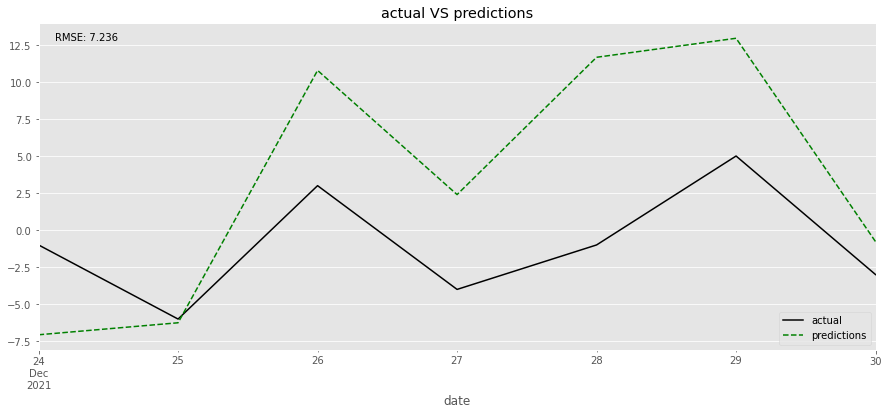

In [127]:
error_stckd, val, pred_stckd = walk_forward_validation(data, 7, 'quantity', config, plot=True)

Модель всё ещё далека от идеала.

## Многошаговая LSTM

Ранее мы пользовались расширяющимся окном для предсказания на каждом следующем шаге, то есть делали прогноз на один день вперед. 

Теперь сделаем модель, которая будет делать прогноз сразу на несколько шагов (дней) вперед.

Напишем функцию `split_sequence()`, которая принимает на вход последовательность, количество последних нескольких шагов на входе и на выходе.

Здесь, в отличие от предыдущих моделей, в качестве целевого признака используется последовательность значений, а не одно значение. Так как мы пользуемся нейронной сетью, то в выходном слое просто укажем соответствующее количество нейронов.

In [128]:
# разбиваем последовательность
def split_sequence(sequence, n_steps_in, n_steps_out):
    features, target = list(), list()
    for i in range(len(sequence)):
        # находим конечный элемент
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # проверяем, не вышли ли мы за пределы последовательности
        if out_end_ix > len(sequence):
            break
        # собираем входные и выходные последовательности
        seq_features, seq_target = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        features.append(seq_features)
        target.append(seq_target)
    return np.array(features), np.array(target)

Пусть в качестве признаков у нас будут 28 последних дней, а предсказывать мы будем каждые семь следующих.

In [129]:
sales_diff = sales_q.diff().dropna()

In [224]:
# выбираем количество шагов
n_steps_in, n_steps_out = 28, 7
# разбиваем на признаки и цель
features, target = split_sequence(sales_diff[:'2021-12-23'], n_steps_in, n_steps_out)
# посмотрим, как будут выглядеть данные
for i in range(len(features)):
   print(features[i], target[i])

[ 26.  -5.   3.   5.   3.  -9. -11.  35.  -7. -22.   3.  12.  -8.   2.
  17. -16.   6.  -4.  27. -24.   4. -14.  20.   3. -25.  47. -43.   3.] [ 10.   5.  -8.   5.   6. -16.   4.]
[ -5.   3.   5.   3.  -9. -11.  35.  -7. -22.   3.  12.  -8.   2.  17.
 -16.   6.  -4.  27. -24.   4. -14.  20.   3. -25.  47. -43.   3.  10.] [  5.  -8.   5.   6. -16.   4.  -6.]
[  3.   5.   3.  -9. -11.  35.  -7. -22.   3.  12.  -8.   2.  17. -16.
   6.  -4.  27. -24.   4. -14.  20.   3. -25.  47. -43.   3.  10.   5.] [ -8.   5.   6. -16.   4.  -6.  18.]
[  5.   3.  -9. -11.  35.  -7. -22.   3.  12.  -8.   2.  17. -16.   6.
  -4.  27. -24.   4. -14.  20.   3. -25.  47. -43.   3.  10.   5.  -8.] [  5.   6. -16.   4.  -6.  18. -14.]
[  3.  -9. -11.  35.  -7. -22.   3.  12.  -8.   2.  17. -16.   6.  -4.
  27. -24.   4. -14.  20.   3. -25.  47. -43.   3.  10.   5.  -8.   5.] [  6. -16.   4.  -6.  18. -14.   3.]
[ -9. -11.  35.  -7. -22.   3.  12.  -8.   2.  17. -16.   6.  -4.  27.
 -24.   4. -14.  20.   3. -25

Приведем входные данные к нужному формату.

In [225]:
n_features = 1
features = features.reshape(features.shape[0], features.shape[1], n_features)

Определим и обучим модель с одним скрытым слоем.

In [226]:
# определяем модель
model_vector_LSTM1 = Sequential()
model_vector_LSTM1.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
model_vector_LSTM1.add(Dense(n_steps_out))
model_vector_LSTM1.compile(optimizer='adam', loss='mse')
# обучаем модель
model_vector_LSTM1.fit(features, target, epochs=120, verbose=1)

Epoch 1/120
10/10 [==============================] - 1s 12ms/step - loss: 118.6456
Epoch 2/120
10/10 [==============================] - 0s 12ms/step - loss: 117.4109
Epoch 3/120
10/10 [==============================] - 0s 13ms/step - loss: 116.6102
Epoch 4/120
10/10 [==============================] - 0s 12ms/step - loss: 115.7155
Epoch 5/120
10/10 [==============================] - 0s 14ms/step - loss: 114.8789
Epoch 6/120
10/10 [==============================] - 0s 12ms/step - loss: 114.0004
Epoch 7/120
10/10 [==============================] - 0s 12ms/step - loss: 113.1877
Epoch 8/120
10/10 [==============================] - 0s 14ms/step - loss: 112.8801
Epoch 9/120
10/10 [==============================] - 0s 13ms/step - loss: 113.3787
Epoch 10/120
10/10 [==============================] - 0s 12ms/step - loss: 113.2663
Epoch 11/120
10/10 [==============================] - 0s 12ms/step - loss: 112.2629
Epoch 12/120
10/10 [==============================] - 0s 13ms/step - loss: 110.9653
E

Определим признаки на входе.

In [216]:
features_input = np.array(sales_diff[:'2021-12-23'].tail(28))
features_input = features_input.reshape(1, n_steps_in, n_features)

Теперь вычислим RMSE на последней неделе и построим график.



In [134]:
prediction = model_vector_LSTM1.predict(features_input, verbose=0)
error = rmse(sales_diff['2021-12-24':], prediction[0])

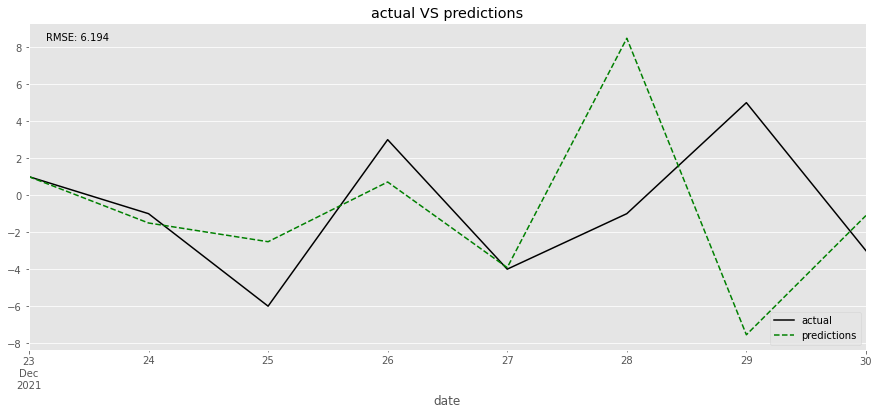

In [135]:
plot_result(8, error, 
            sales_diff['2021-12-23':], 
            np.concatenate(([sales_diff['2021-12-23']], prediction[0])))

Попробуем добавить ещё один слой.

In [136]:
# определяем модель
model_vector_LSTM2 = Sequential()
model_vector_LSTM2.add(LSTM(30, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_vector_LSTM2.add(LSTM(110, activation='relu'))
model_vector_LSTM2.add(Dense(n_steps_out))
model_vector_LSTM2.compile(optimizer='adam', loss='mse')
# обучаем модель
model_vector_LSTM2.fit(features, target, epochs=120, verbose=1)

Epoch 1/120
10/10 [==============================] - 4s 51ms/step - loss: 118.0332
Epoch 2/120
10/10 [==============================] - 1s 50ms/step - loss: 117.8657
Epoch 3/120
10/10 [==============================] - 1s 51ms/step - loss: 117.8432
Epoch 4/120
10/10 [==============================] - 0s 50ms/step - loss: 117.8312
Epoch 5/120
10/10 [==============================] - 1s 52ms/step - loss: 117.7976
Epoch 6/120
10/10 [==============================] - 1s 54ms/step - loss: 117.7444
Epoch 7/120
10/10 [==============================] - 1s 113ms/step - loss: 117.7008
Epoch 8/120
10/10 [==============================] - 0s 50ms/step - loss: 117.4331
Epoch 9/120
10/10 [==============================] - 1s 52ms/step - loss: 116.1831
Epoch 10/120
10/10 [==============================] - 1s 50ms/step - loss: 115.1513
Epoch 11/120
10/10 [==============================] - 1s 53ms/step - loss: 112.6232
Epoch 12/120
10/10 [==============================] - 1s 50ms/step - loss: 111.5622


Вычислим RMSE и построим график.

In [137]:
prediction = model_vector_LSTM2.predict(features_input, verbose=0)
error = rmse(sales_diff['2021-12-24':], prediction[0])
error

4.269215704174214

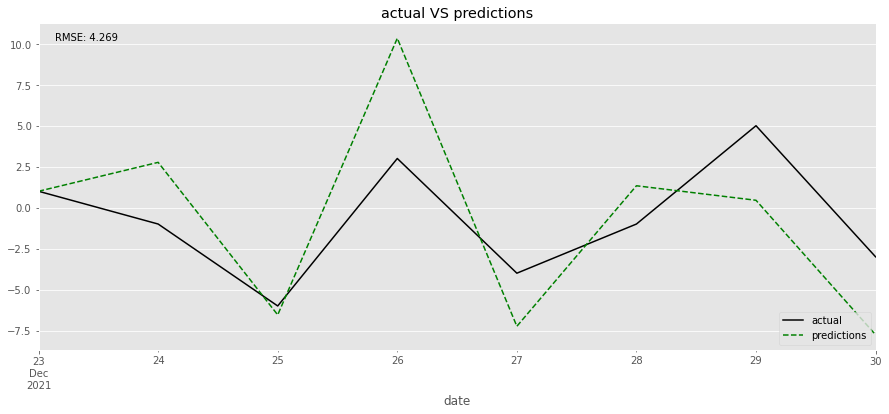

In [138]:
plot_result(8, error, 
            sales_diff['2021-12-23':], 
            np.concatenate(([sales_diff['2021-12-23']], prediction[0])))

Сделаем сеть сложнее.

In [227]:
# определяем модель
model_vector_LSTM3 = Sequential()
model_vector_LSTM3.add(LSTM(30, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_vector_LSTM3.add(LSTM(40, activation='relu', return_sequences=True))
model_vector_LSTM3.add(LSTM(70, activation='relu'))
model_vector_LSTM3.add(Dense(n_steps_out))
model_vector_LSTM3.compile(optimizer='adam', loss='mse')
# обучаем модель
model_vector_LSTM3.fit(features, target, epochs=120, verbose=1)

Epoch 1/120
10/10 [==============================] - 60s 39ms/step - loss: 117.9580
Epoch 2/120
10/10 [==============================] - 1s 61ms/step - loss: 117.8687
Epoch 3/120
10/10 [==============================] - 1s 64ms/step - loss: 117.8294
Epoch 4/120
10/10 [==============================] - 1s 66ms/step - loss: 117.7844
Epoch 5/120
10/10 [==============================] - 1s 68ms/step - loss: 117.7048
Epoch 6/120
10/10 [==============================] - 0s 49ms/step - loss: 117.5560
Epoch 7/120
10/10 [==============================] - 0s 40ms/step - loss: 117.1133
Epoch 8/120
10/10 [==============================] - 0s 39ms/step - loss: 115.5281
Epoch 9/120
10/10 [==============================] - 0s 39ms/step - loss: 113.7559
Epoch 10/120
10/10 [==============================] - 0s 38ms/step - loss: 112.5152
Epoch 11/120
10/10 [==============================] - 0s 39ms/step - loss: 111.6843
Epoch 12/120
10/10 [==============================] - 0s 37ms/step - loss: 109.8621


In [228]:
prediction = model_vector_LSTM3.predict(features_input, verbose=0)
error = rmse(sales_diff['2021-12-24':], prediction[0])
error

5.306878018027217

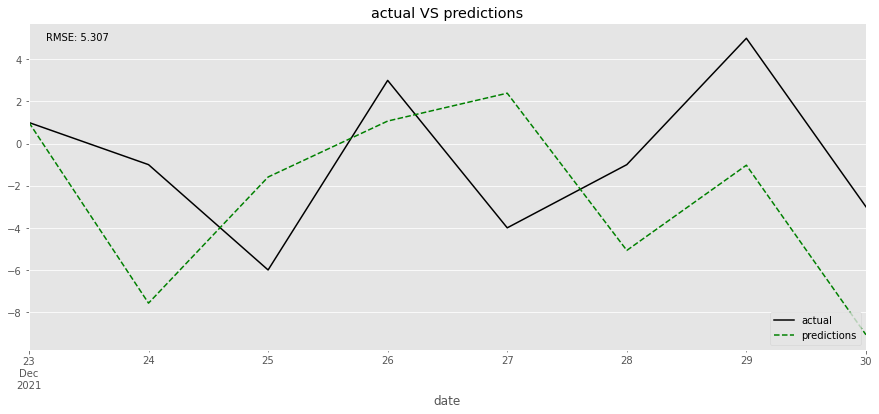

In [229]:
plot_result(8, error, 
            sales_diff['2021-12-23':], 
            np.concatenate(([sales_diff['2021-12-23']], prediction[0])))

Попробуем другое количество нейронов в скрытых слоях.

In [171]:
# определяем модель
model_vector_LSTM4 = Sequential()
model_vector_LSTM4.add(LSTM(28, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_vector_LSTM4.add(LSTM(35, activation='relu', return_sequences=True))
model_vector_LSTM4.add(LSTM(77, activation='relu'))
model_vector_LSTM4.add(Dense(n_steps_out))
model_vector_LSTM4.compile(optimizer='adam', loss='mse')
# обучаем модель
model_vector_LSTM4.fit(features, target, epochs=120, verbose=1)

Epoch 1/120
10/10 [==============================] - 5s 40ms/step - loss: 116.2020
Epoch 2/120
10/10 [==============================] - 0s 40ms/step - loss: 116.1203
Epoch 3/120
10/10 [==============================] - 0s 38ms/step - loss: 116.1011
Epoch 4/120
10/10 [==============================] - 0s 39ms/step - loss: 116.0937
Epoch 5/120
10/10 [==============================] - 0s 38ms/step - loss: 116.0711
Epoch 6/120
10/10 [==============================] - 0s 38ms/step - loss: 116.0382
Epoch 7/120
10/10 [==============================] - 0s 39ms/step - loss: 115.9756
Epoch 8/120
10/10 [==============================] - 0s 38ms/step - loss: 115.9996
Epoch 9/120
10/10 [==============================] - 0s 40ms/step - loss: 115.7449
Epoch 10/120
10/10 [==============================] - 0s 38ms/step - loss: 115.4903
Epoch 11/120
10/10 [==============================] - 0s 40ms/step - loss: 114.5592
Epoch 12/120
10/10 [==============================] - 0s 38ms/step - loss: 113.2185
E

In [172]:
prediction = model_vector_LSTM4.predict(features_input, verbose=0)
error = rmse(sales_diff['2021-12-24':], prediction[0])
error

6.677857061958654

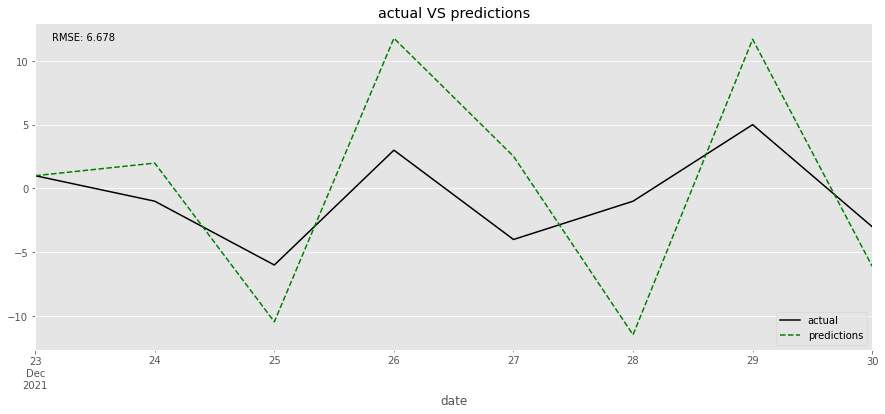

In [173]:
plot_result(8, error, 
            sales_diff['2021-12-23':], 
            np.concatenate(([sales_diff['2021-12-23']], prediction[0])))

In [189]:
# определяем модель
model_vector_LSTM5 = Sequential()
model_vector_LSTM5.add(LSTM(14, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_vector_LSTM5.add(LSTM(28, activation='relu', return_sequences=True))
model_vector_LSTM5.add(LSTM(70, activation='relu'))
model_vector_LSTM5.add(Dense(n_steps_out))
model_vector_LSTM5.compile(optimizer='adam', loss='mse')
# обучаем модель
model_vector_LSTM5.fit(features, target, epochs=120, verbose=1)

Epoch 1/120
10/10 [==============================] - 4s 101ms/step - loss: 116.3946
Epoch 2/120
10/10 [==============================] - 0s 47ms/step - loss: 116.1132
Epoch 3/120
10/10 [==============================] - 0s 35ms/step - loss: 116.0882
Epoch 4/120
10/10 [==============================] - 0s 37ms/step - loss: 116.0689
Epoch 5/120
10/10 [==============================] - 0s 37ms/step - loss: 116.0506
Epoch 6/120
10/10 [==============================] - 0s 36ms/step - loss: 116.0309
Epoch 7/120
10/10 [==============================] - 0s 37ms/step - loss: 116.0159
Epoch 8/120
10/10 [==============================] - 0s 36ms/step - loss: 116.0042
Epoch 9/120
10/10 [==============================] - 0s 37ms/step - loss: 116.0049
Epoch 10/120
10/10 [==============================] - 0s 36ms/step - loss: 115.9041
Epoch 11/120
10/10 [==============================] - 0s 36ms/step - loss: 115.8479
Epoch 12/120
10/10 [==============================] - 0s 37ms/step - loss: 115.7030


In [190]:
prediction = model_vector_LSTM5.predict(features_input, verbose=0)
error = rmse(sales_diff['2021-12-24':], prediction[0])
error

5.81318634524251

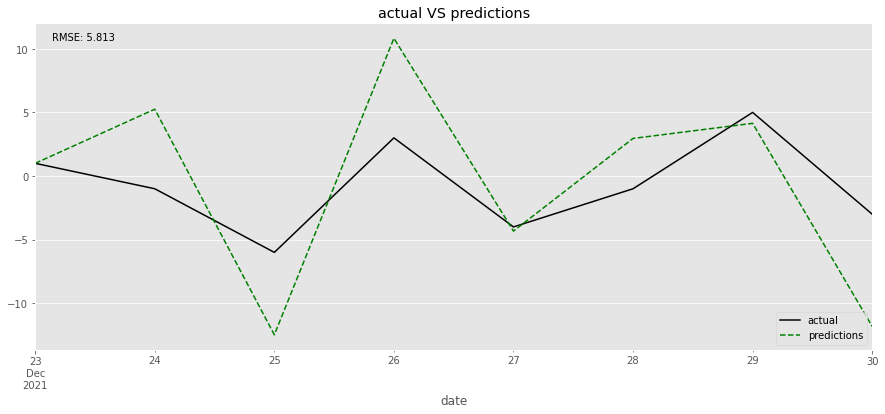

In [191]:
plot_result(8, error, 
            sales_diff['2021-12-23':], 
            np.concatenate(([sales_diff['2021-12-23']], prediction[0])))

Лучшей из опробованных конфигураций оказалась конфигурация модели `model_vector_LSTM2`.

# ИТОГ


Мы построили несколько моделей, однако последний тип модели многошаговой LSTM отличается от предыдущих тем, что она возвращает прогноз на ближайшие 7 дней вперед. В предыдущих моделях чтобы повысить качество предсказаний, мы делали одношаговые прогнозы и обучали модель на каждом шаге с учётом последнего реального значения. Таким образом предсказание не далеко отклонялось от реальных данных. Поэтому модель SARIMA имеет лучшее качество в сравнении с остальными моделями. 

Однако если мы проведем симуляцию, подставляя последние предсказанные значения на вход модели, то за несколько шагов SARIMA сведётся к предсказанию последним значением. 

Поэтому более интересным является многошаговый прогноз LSTM. К тому же RMSE при валидации не слишком сильно уступает модели SARIMA, и выше, чем у градиентного бустинга и одношаговых LSTM-моделей.

Конечно, мы перебрали лишь некоторые модели LSTM. И если бы мы многократно запускали симуляцию одной и тоже конфигурации модели без фиксации random state, то можно было бы с большей уверенностью судить о качестве той или иной нейросети.

Обучим лучшую модель заново с учётом последней недели и сделаем прогноз.

In [230]:
n_steps_in, n_steps_out = 28, 7
features_, target_ = split_sequence(sales_diff, n_steps_in, n_steps_out)

In [231]:
# определяем модель
model_vector_LSTM = Sequential()
model_vector_LSTM.add(LSTM(30, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_vector_LSTM.add(LSTM(110, activation='relu'))
model_vector_LSTM.add(Dense(n_steps_out))
model_vector_LSTM.compile(optimizer='adam', loss='mse')
# обучаем модель
model_vector_LSTM.fit(features_, target_, epochs=120, verbose=1)

Epoch 1/120
10/10 [==============================] - 3s 34ms/step - loss: 116.3928
Epoch 2/120
10/10 [==============================] - 0s 33ms/step - loss: 115.7341
Epoch 3/120
10/10 [==============================] - 0s 34ms/step - loss: 114.6666
Epoch 4/120
10/10 [==============================] - 0s 33ms/step - loss: 113.2666
Epoch 5/120
10/10 [==============================] - 0s 34ms/step - loss: 112.5899
Epoch 6/120
10/10 [==============================] - 0s 35ms/step - loss: 111.6240
Epoch 7/120
10/10 [==============================] - 0s 34ms/step - loss: 109.9180
Epoch 8/120
10/10 [==============================] - 0s 33ms/step - loss: 109.1073
Epoch 9/120
10/10 [==============================] - 0s 34ms/step - loss: 108.8127
Epoch 10/120
10/10 [==============================] - 0s 35ms/step - loss: 107.4500
Epoch 11/120
10/10 [==============================] - 0s 33ms/step - loss: 106.3293
Epoch 12/120
10/10 [==============================] - 0s 34ms/step - loss: 104.5637
E

In [232]:
features_input_ = np.array(sales_diff.tail(28))
features_input_ = features_input_.reshape(1, n_steps_in, n_features)

In [233]:
forecast = model_vector_LSTM.predict(features_input_, verbose=0)

Итак, прогноз разностей продаж на неделю вперёд исходя из данных о разностях за последние 4 недели.

In [234]:
forecast[0]

array([-2.7339063,  1.3911389, -1.0647684,  3.6626263, -5.723689 ,
        4.9648724, -3.0692432], dtype=float32)

Данные о суммарном количестве продаж за день хранятся в сирии `sales_q`.

In [235]:
sales_q.tail()

date
2021-12-26    11
2021-12-27     7
2021-12-28     6
2021-12-29    11
2021-12-30     8
Name: actual sales quantity, dtype: int64

Отталкиваясь от последнего значения, дополним этот временной ряд прогнозируемыми значениями.

In [236]:
sales_forecast = []
sales_forecast_idx = []
last_value = sales_q.tail(1)[0]
last_idx = sales_q.tail(1).index[0]
sales_forecast.append(last_value) # для красоты графика
sales_forecast_idx.append(last_idx) # для красоты графика
for predicted_diff in range(len(forecast[0])):
  predicted_value = last_value + forecast[0][predicted_diff]
  predicted_value_idx = last_idx + timedelta(days=1)
  sales_forecast.append(round(predicted_value))
  sales_forecast_idx.append(predicted_value_idx)
  last_value = predicted_value
  last_idx = predicted_value_idx
sales_forecast = pd.DataFrame(data=sales_forecast, index=sales_forecast_idx, columns=['forecasted sales quantity'])

In [237]:
sales_forecast

,forecasted sales quantity
2021-12-30,8
2021-12-31,5
2022-01-01,7
2022-01-02,6
2022-01-03,9
2022-01-04,4
2022-01-05,8
2022-01-06,5


Построим итоговый график продаж, продолжаемый прогнозируемыми значениями.

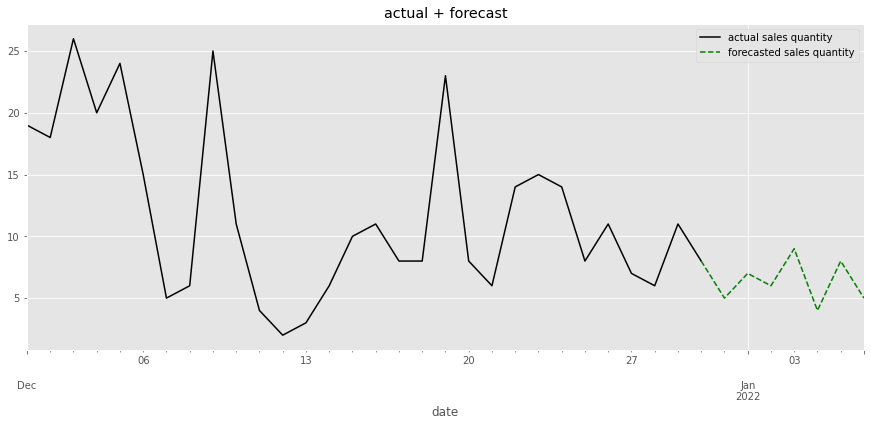

In [238]:
sales_q.name = 'actual sales quantity'
ax = sales_q['12-01-2021':].plot(figsize=(15,6), color='black', title='actual + forecast')
sales_forecast.plot(ax=ax, style='--', color='green')
ax.legend(loc='upper right')
plt.show();

Сохраним результат на диске.

In [239]:
sales_forecast.columns = ['quantities']
sales_forecast.to_csv(PATH+'sales_forecast.csv')